In [1]:
# This is for compatibility with google colab
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MultiOmicsIntegration/comp-401

Mounted at /content/drive
/content/drive/MyDrive/MultiOmicsIntegration/comp-401


In [2]:
from multi_omics_integration.func import *
from multi_omics_integration.classification_pipeline import *
from multi_omics_integration.processing import *
from multi_omics_integration.evaluation import *
import json
import warnings
from pandas.errors import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.filterwarnings('ignore', 'Solver terminated early.*')

In [3]:
%cd /content/drive/MyDrive/MultiOmicsIntegration/comp-401/notebooks

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/notebooks


# Subtyping (RNA, CNV, RPPA)

In [ ]:
datasets = {
            'rna': '../data/kipan/RNASeq.csv',
            'cnv': '../data/kipan/CNV.csv',
            'rppa': '../data/kipan/RPPA.csv',
}

labels = '../data/kipan/Clinical.csv'

In [ ]:
subtypes = pd.read_csv(labels, index_col=0)
data = {}

for modality in datasets:
    data[modality] = pd.read_csv(datasets[modality], index_col=0)
    print(modality, data[modality].shape)

rna (736, 20190)
cnv (736, 24776)
rppa (736, 166)


## Preprocessing

### Removing low-variance + null features

In [ ]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold(X, percentage=0.10):
    var_thr = VarianceThreshold(threshold=percentage) #Removing both constant and quasi-constant (less than 1% variance)

    X_new = var_thr.fit_transform(X)

    column_names = X.columns[var_thr.get_support()]

    return pd.DataFrame(X_new, columns=column_names)

In [ ]:
new_data = {}
for modality in data:
    new_data[modality] = variance_threshold(data[modality], percentage=0.10)
    print(modality, new_data[modality].shape)

rna (736, 19042)
cnv (736, 5003)
rppa (736, 91)


In [ ]:
import pandas as pd

X = {}

# Convert numpy array to DataFrame
for modality in new_data:
    X[modality] = pd.DataFrame(new_data[modality])
    X[modality] = X[modality].dropna(axis=1)
    print(modality, X[modality].shape)

rna (736, 19042)
cnv (736, 5003)
rppa (736, 75)


In [ ]:
subtypes['histological_type'].value_counts()

kidneyclearcellrenalcarcinoma        467
kidneypapillaryrenalcellcarcinoma    206
kidneychromophobe                     63
Name: histological_type, dtype: int64

In [ ]:
enc = LabelEncoder()
y = enc.fit_transform(subtypes['histological_type'])
enc.inverse_transform([0, 1, 2])

array(['kidneychromophobe', 'kidneyclearcellrenalcarcinoma',
       'kidneypapillaryrenalcellcarcinoma'], dtype=object)

## Base Learners

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

estimators = [
    ("logistic", make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=1000, n_jobs=-1))),
    ("balanced_random_forest", BalancedRandomForestClassifier(random_state=0, n_jobs=-1, sampling_strategy='all', replacement=True)),
    ("deep_nn", make_pipeline(StandardScaler(), MLPClassifier(random_state=0))),
    ("svc", make_pipeline(StandardScaler(), SVC(random_state=0, kernel='linear', max_iter=1000)))
]

estimator_names = [estimator[0] for estimator in estimators]

In [ ]:
kipan_scoring = {"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)}

In [ ]:
base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
    base_scores[modality], base_metrics_df[modality] = get_individual_scores(X[modality], y, estimators, scoring=kipan_scoring)

In [ ]:
display(base_metrics_df['rna']), display(base_metrics_df['cnv']), display(base_metrics_df['rppa'])

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.966 +/- 0.015,0.961 +/- 0.027,0.966 +/- 0.015,0.938 +/- 0.090,0.964 +/- 0.023,0.981 +/- 0.018
balanced_random_forest,0.954 +/- 0.018,0.961 +/- 0.018,0.955 +/- 0.018,0.969 +/- 0.062,0.946 +/- 0.030,0.966 +/- 0.033
deep_nn,0.951 +/- 0.008,0.940 +/- 0.023,0.951 +/- 0.008,0.906 +/- 0.090,0.953 +/- 0.020,0.961 +/- 0.033
svc,0.965 +/- 0.018,0.960 +/- 0.028,0.965 +/- 0.017,0.938 +/- 0.090,0.962 +/- 0.025,0.981 +/- 0.018


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.861 +/- 0.031,0.792 +/- 0.054,0.859 +/- 0.033,0.685 +/- 0.114,0.929 +/- 0.014,0.762 +/- 0.090
balanced_random_forest,0.886 +/- 0.014,0.883 +/- 0.038,0.888 +/- 0.014,0.874 +/- 0.116,0.887 +/- 0.014,0.888 +/- 0.048
deep_nn,0.857 +/- 0.013,0.801 +/- 0.066,0.855 +/- 0.016,0.687 +/- 0.230,0.899 +/- 0.018,0.815 +/- 0.041
svc,0.716 +/- 0.153,0.689 +/- 0.114,0.722 +/- 0.149,0.650 +/- 0.153,0.745 +/- 0.174,0.671 +/- 0.155


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.750 +/- 0.038,0.590 +/- 0.050,0.741 +/- 0.037,0.283 +/- 0.100,0.871 +/- 0.050,0.616 +/- 0.060
balanced_random_forest,0.909 +/- 0.032,0.891 +/- 0.041,0.910 +/- 0.031,0.859 +/- 0.103,0.925 +/- 0.034,0.888 +/- 0.057
deep_nn,0.921 +/- 0.016,0.852 +/- 0.041,0.919 +/- 0.018,0.717 +/- 0.100,0.974 +/- 0.011,0.864 +/- 0.037
svc,0.634 +/- 0.021,0.573 +/- 0.028,0.650 +/- 0.018,0.463 +/- 0.075,0.685 +/- 0.038,0.572 +/- 0.082


(None, None, None)

In [ ]:
display(base_metrics_df['rna']), display(base_metrics_df['cnv']), display(base_metrics_df['rppa'])

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.966 +/- 0.016,0.965 +/- 0.033,0.967 +/- 0.016,0.954 +/- 0.092,0.964 +/- 0.022,0.977 +/- 0.015
balanced_random_forest,0.950 +/- 0.009,0.960 +/- 0.020,0.951 +/- 0.009,0.969 +/- 0.062,0.938 +/- 0.014,0.972 +/- 0.009
deep_nn,0.950 +/- 0.022,0.940 +/- 0.037,0.950 +/- 0.022,0.921 +/- 0.072,0.959 +/- 0.018,0.939 +/- 0.058
svc,0.969 +/- 0.019,0.966 +/- 0.034,0.969 +/- 0.019,0.954 +/- 0.092,0.968 +/- 0.025,0.977 +/- 0.015


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.882 +/- 0.023,0.829 +/- 0.047,0.881 +/- 0.022,0.746 +/- 0.122,0.934 +/- 0.030,0.808 +/- 0.026
balanced_random_forest,0.895 +/- 0.014,0.880 +/- 0.038,0.897 +/- 0.013,0.842 +/- 0.128,0.904 +/- 0.019,0.892 +/- 0.045
deep_nn,0.889 +/- 0.027,0.849 +/- 0.067,0.889 +/- 0.027,0.774 +/- 0.168,0.919 +/- 0.034,0.855 +/- 0.044
svc,0.855 +/- 0.016,0.818 +/- 0.030,0.856 +/- 0.015,0.764 +/- 0.096,0.895 +/- 0.034,0.794 +/- 0.053


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.785 +/- 0.016,0.682 +/- 0.015,0.785 +/- 0.016,0.494 +/- 0.068,0.872 +/- 0.015,0.681 +/- 0.057
balanced_random_forest,0.923 +/- 0.016,0.915 +/- 0.029,0.924 +/- 0.016,0.922 +/- 0.069,0.944 +/- 0.026,0.878 +/- 0.041
deep_nn,0.954 +/- 0.021,0.906 +/- 0.051,0.953 +/- 0.022,0.813 +/- 0.124,0.994 +/- 0.009,0.911 +/- 0.028
svc,0.752 +/- 0.016,0.712 +/- 0.039,0.761 +/- 0.013,0.669 +/- 0.145,0.804 +/- 0.032,0.662 +/- 0.056


(None, None, None)

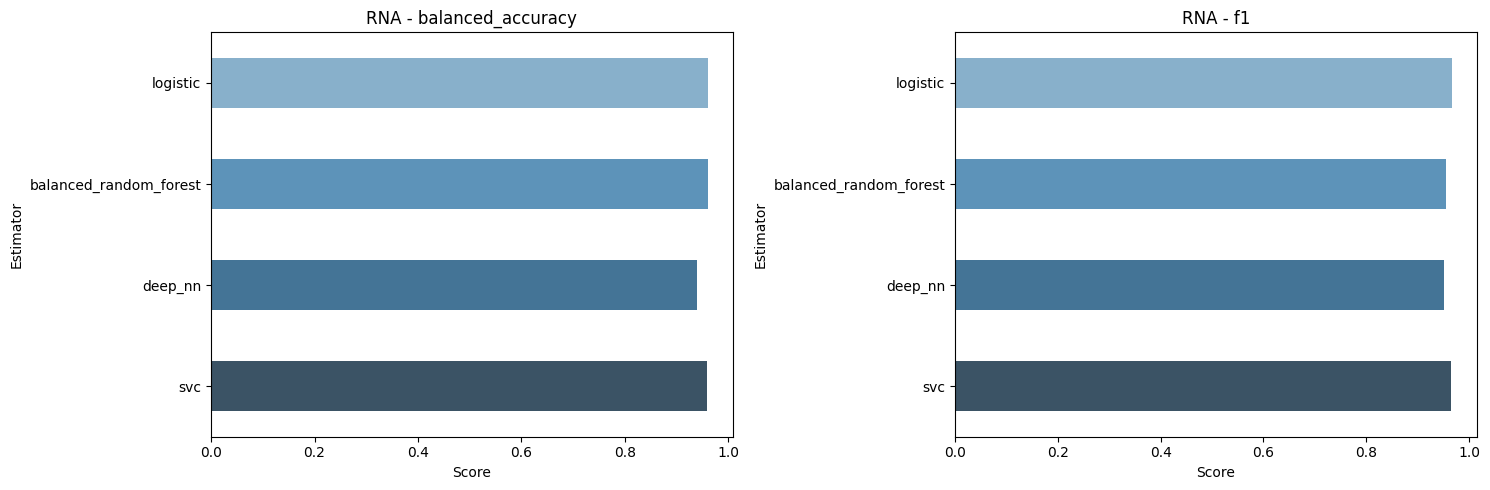

In [ ]:
plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

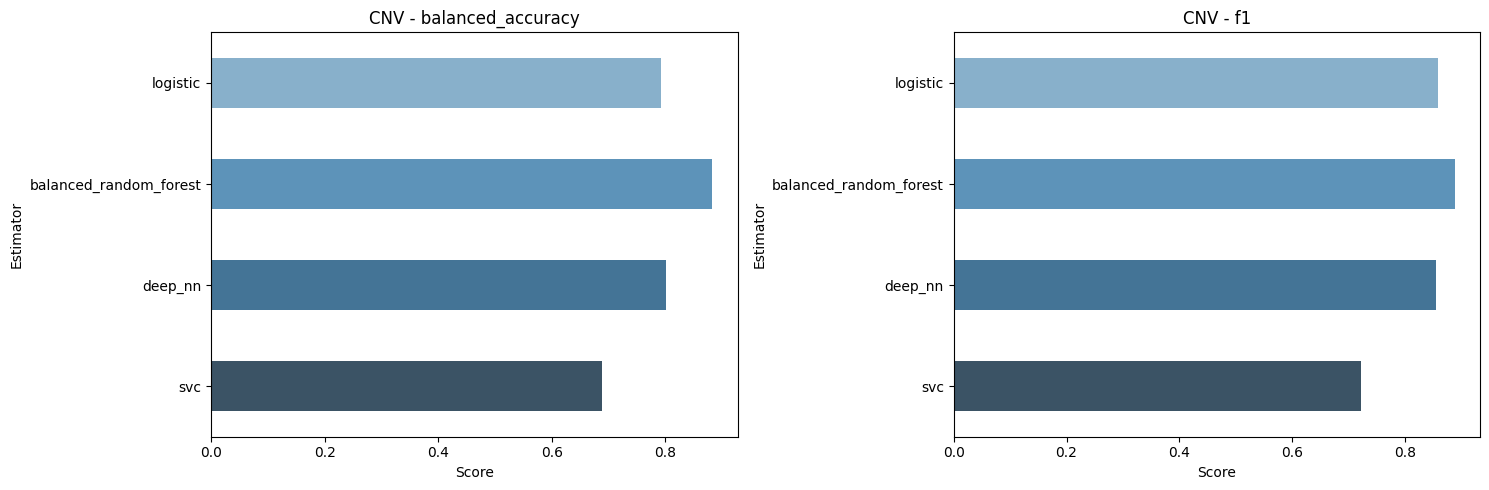

In [ ]:
plot_bar_scores(estimator_names, base_scores['cnv'], 'CNV', metrics=['balanced_accuracy', 'f1'])

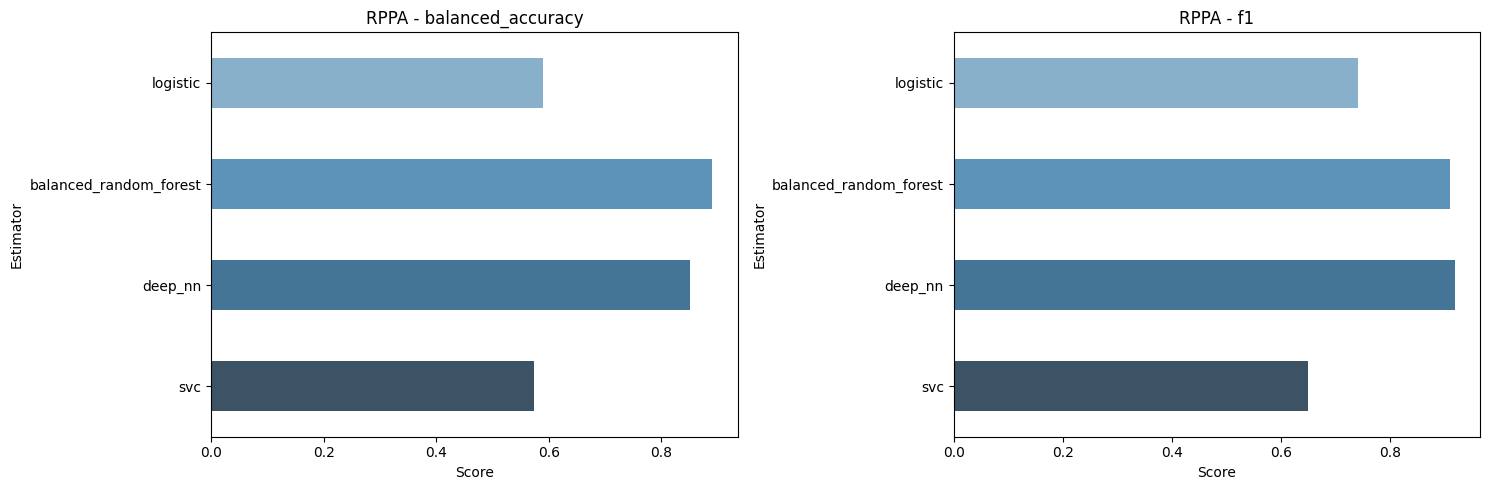

In [ ]:
plot_bar_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  


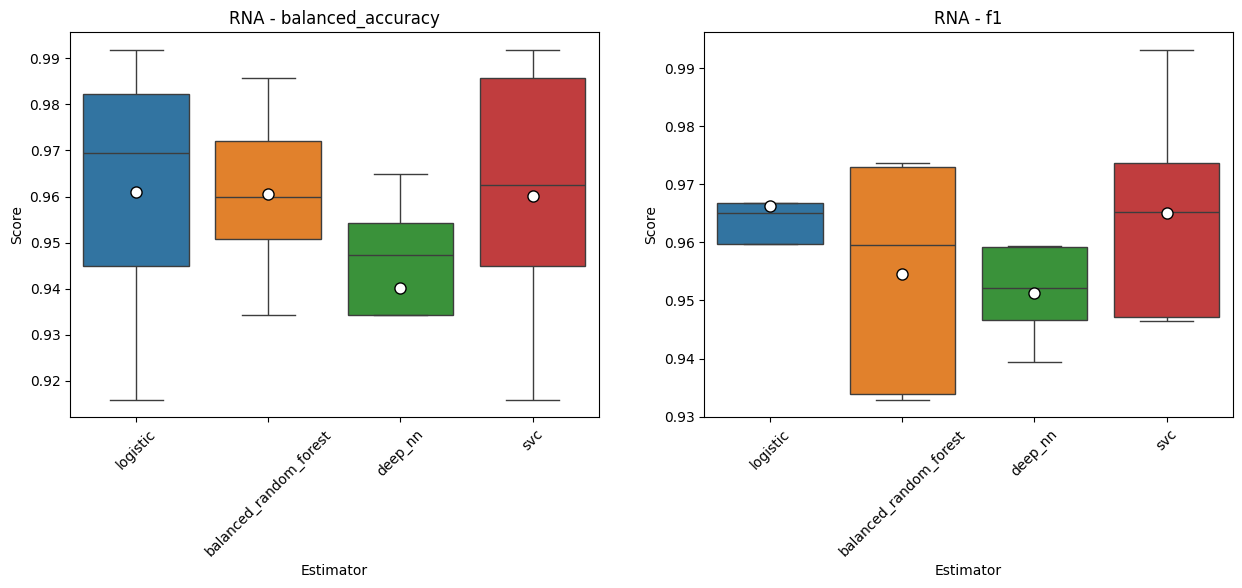

In [ ]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  


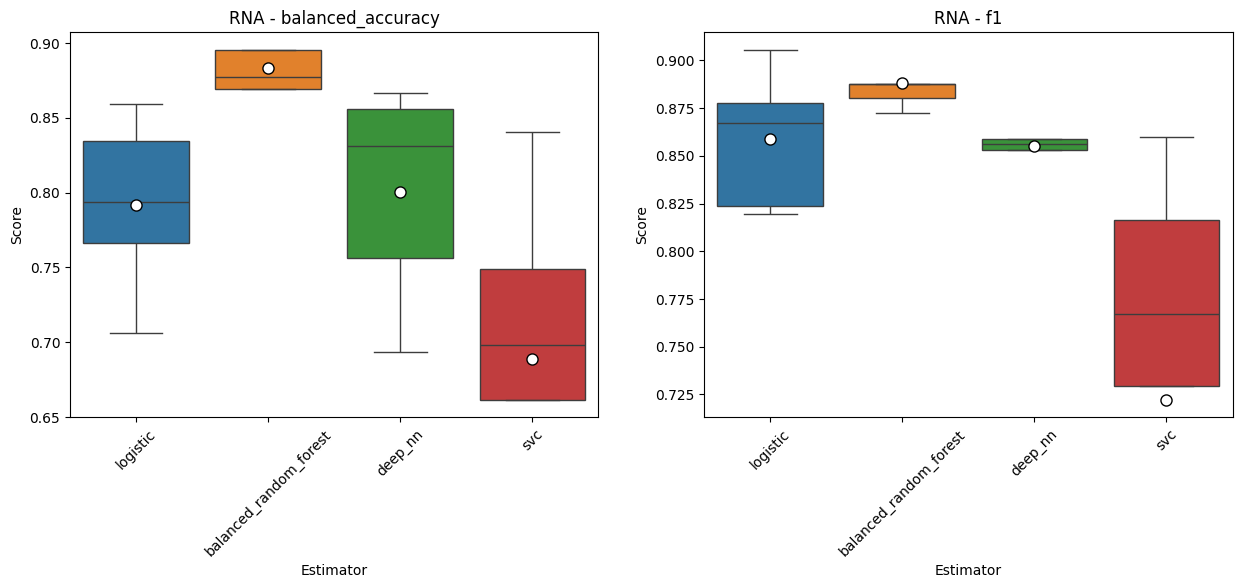

In [ ]:
plot_box_scores(estimator_names, base_scores['cnv'], 'RNA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  


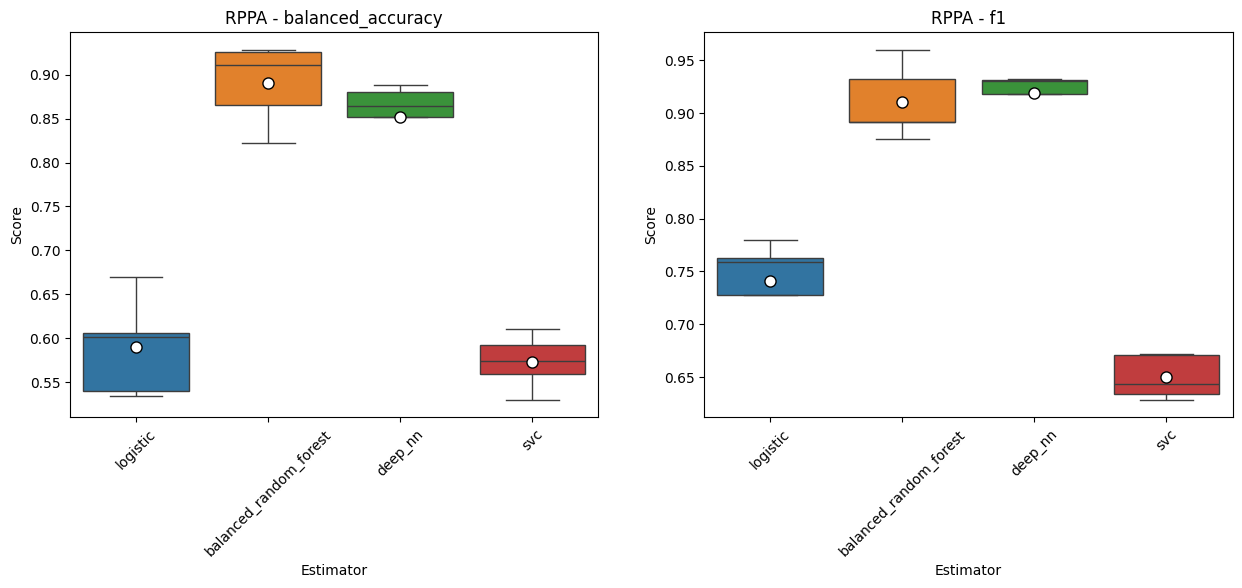

In [ ]:
plot_box_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

## Modality Ensembles

In [ ]:
from multi_omics_integration.classification_pipeline import Debugger

class ModalityPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, estimator_list=None, feature_select=None, final_estimator=LogisticRegression(random_state=0, n_jobs=-1), cv=5, n_jobs=-1, stack_method='auto'):
        self.cv = cv
        self.estimator_list = estimator_list
        self.feature_select = feature_select
        self.final_estimator = final_estimator
        self.n_jobs=n_jobs
        self.stack_method = stack_method

    def _get_model(self):
        self.cv_ = StratifiedKFold(n_splits=self.cv, random_state=0, shuffle=True)
        self.final_estimator_ = Pipeline([('imputer', SimpleImputer(strategy='median')), ('final', self.final_estimator)])

        stacking = StackingClassifier(estimators=self.estimator_list, final_estimator=self.final_estimator_, cv=self.cv_, stack_method=self.stack_method, n_jobs=self.n_jobs)

        if self.feature_select != None:
            model = Pipeline([('feature_selection', self.feature_select), ('clf', stacking)])
        else:
            model = stacking

        return model

    def fit(self, X, y):
        self.model_ = self._get_model()
        self.model_.fit(X, y)
        self.classes_ = self.model_.classes_
        self.coef_ = self.model_.final_estimator_.named_steps['final'].coef_

        return self

    def predict(self, X):
        return self.model_.predict(X)

    def predict_proba(self, X):
        return self.model_.predict_proba(X)

In [ ]:
classifiers = {}

for modality in datasets:
    classifiers[modality] = ModalityPipeline(estimators, cv=3)

In [ ]:
modality_metrics = pd.DataFrame()
scores = {}

for modality in tqdm(datasets):
    scores[modality], df = get_cross_metrics(classifiers[modality], X[modality], y, modality, scoring=kipan_scoring)
    modality_metrics = pd.concat([modality_metrics, df])

100%|██████████| 3/3 [20:25<00:00, 408.36s/it]


In [ ]:
modality_metrics

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna,0.965 +/- 0.014,0.958 +/- 0.026,0.965 +/- 0.014,0.938 +/- 0.090,0.966 +/- 0.023,0.971 +/- 0.028
cnv,0.885 +/- 0.024,0.835 +/- 0.057,0.883 +/- 0.025,0.749 +/- 0.146,0.927 +/- 0.013,0.830 +/- 0.041
rppa,0.939 +/- 0.011,0.882 +/- 0.023,0.938 +/- 0.011,0.764 +/- 0.082,0.979 +/- 0.012,0.903 +/- 0.027


In [ ]:
modality_metrics

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna,0.968 +/- 0.018,0.961 +/- 0.032,0.968 +/- 0.018,0.937 +/- 0.090,0.968 +/- 0.025,0.977 +/- 0.015
cnv,0.915 +/- 0.020,0.895 +/- 0.046,0.916 +/- 0.020,0.858 +/- 0.132,0.934 +/- 0.022,0.893 +/- 0.058
rppa,0.957 +/- 0.017,0.918 +/- 0.037,0.956 +/- 0.018,0.844 +/- 0.084,0.987 +/- 0.016,0.925 +/- 0.035


In [ ]:
modality_metrics

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna,0.968 +/- 0.018,0.960 +/- 0.037,0.968 +/- 0.018,0.938 +/- 0.090,0.970 +/- 0.018,0.972 +/- 0.018
cnv,0.893 +/- 0.029,0.851 +/- 0.060,0.892 +/- 0.030,0.781 +/- 0.147,0.932 +/- 0.023,0.841 +/- 0.056
rppa,0.936 +/- 0.026,0.883 +/- 0.051,0.934 +/- 0.028,0.781 +/- 0.099,0.977 +/- 0.008,0.891 +/- 0.064


In [ ]:
estimator_names = [
    "logistic",
    "balanced_random_forest",
    "deep_nn",
    "svc",
    "stacking"
]
all_scores = {}

for modality in base_scores:
    all_scores[modality] = {}
    for i in range(len(base_scores[modality])):
        all_scores[modality][estimator_names[i]] = base_scores[modality][i]

    all_scores[modality]['stacking'] = scores[modality]


In [ ]:
# Convert and write JSON object to file
with open("results/kipan/subtyping/kipan_modality_results.json", "w") as outfile:
    json.dump(scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

In [ ]:
# Convert and write JSON object to file
with open("results/kipan/subtyping/kipan_base_learner_modality_results.json", "w") as outfile:
    json.dump(all_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

### Scoring

In [ ]:
all_metrics = {}

for modality in datasets:
    all_metrics[modality] = pd.concat([base_metrics_df[modality], modality_metrics.loc[[modality]]])
    all_metrics[modality].rename_axis(index={modality: 'stacking'}, inplace=True)

In [ ]:
display(all_metrics['rna'], all_metrics['cnv'], all_metrics['rppa'])

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.966 +/- 0.015,0.961 +/- 0.027,0.966 +/- 0.015,0.938 +/- 0.090,0.964 +/- 0.023,0.981 +/- 0.018
balanced_random_forest,0.954 +/- 0.018,0.961 +/- 0.018,0.955 +/- 0.018,0.969 +/- 0.062,0.946 +/- 0.030,0.966 +/- 0.033
deep_nn,0.951 +/- 0.008,0.940 +/- 0.023,0.951 +/- 0.008,0.906 +/- 0.090,0.953 +/- 0.020,0.961 +/- 0.033
svc,0.965 +/- 0.018,0.960 +/- 0.028,0.965 +/- 0.017,0.938 +/- 0.090,0.962 +/- 0.025,0.981 +/- 0.018
rna,0.965 +/- 0.014,0.958 +/- 0.026,0.965 +/- 0.014,0.938 +/- 0.090,0.966 +/- 0.023,0.971 +/- 0.028


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.861 +/- 0.031,0.792 +/- 0.054,0.859 +/- 0.033,0.685 +/- 0.114,0.929 +/- 0.014,0.762 +/- 0.090
balanced_random_forest,0.886 +/- 0.014,0.883 +/- 0.038,0.888 +/- 0.014,0.874 +/- 0.116,0.887 +/- 0.014,0.888 +/- 0.048
deep_nn,0.857 +/- 0.013,0.801 +/- 0.066,0.855 +/- 0.016,0.687 +/- 0.230,0.899 +/- 0.018,0.815 +/- 0.041
svc,0.716 +/- 0.153,0.689 +/- 0.114,0.722 +/- 0.149,0.650 +/- 0.153,0.745 +/- 0.174,0.671 +/- 0.155
cnv,0.885 +/- 0.024,0.835 +/- 0.057,0.883 +/- 0.025,0.749 +/- 0.146,0.927 +/- 0.013,0.830 +/- 0.041


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.750 +/- 0.038,0.590 +/- 0.050,0.741 +/- 0.037,0.283 +/- 0.100,0.871 +/- 0.050,0.616 +/- 0.060
balanced_random_forest,0.909 +/- 0.032,0.891 +/- 0.041,0.910 +/- 0.031,0.859 +/- 0.103,0.925 +/- 0.034,0.888 +/- 0.057
deep_nn,0.921 +/- 0.016,0.852 +/- 0.041,0.919 +/- 0.018,0.717 +/- 0.100,0.974 +/- 0.011,0.864 +/- 0.037
svc,0.634 +/- 0.021,0.573 +/- 0.028,0.650 +/- 0.018,0.463 +/- 0.075,0.685 +/- 0.038,0.572 +/- 0.082
rppa,0.939 +/- 0.011,0.882 +/- 0.023,0.938 +/- 0.011,0.764 +/- 0.082,0.979 +/- 0.012,0.903 +/- 0.027


In [ ]:
display(all_metrics['rna'], all_metrics['cnv'], all_metrics['rppa'])

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.966 +/- 0.016,0.965 +/- 0.033,0.967 +/- 0.016,0.954 +/- 0.092,0.964 +/- 0.022,0.977 +/- 0.015
balanced_random_forest,0.950 +/- 0.009,0.960 +/- 0.020,0.951 +/- 0.009,0.969 +/- 0.062,0.938 +/- 0.014,0.972 +/- 0.009
deep_nn,0.950 +/- 0.022,0.940 +/- 0.037,0.950 +/- 0.022,0.921 +/- 0.072,0.959 +/- 0.018,0.939 +/- 0.058
svc,0.969 +/- 0.019,0.966 +/- 0.034,0.969 +/- 0.019,0.954 +/- 0.092,0.968 +/- 0.025,0.977 +/- 0.015
rna,0.968 +/- 0.018,0.961 +/- 0.032,0.968 +/- 0.018,0.937 +/- 0.090,0.968 +/- 0.025,0.977 +/- 0.015


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.882 +/- 0.023,0.829 +/- 0.047,0.881 +/- 0.022,0.746 +/- 0.122,0.934 +/- 0.030,0.808 +/- 0.026
balanced_random_forest,0.895 +/- 0.014,0.880 +/- 0.038,0.897 +/- 0.013,0.842 +/- 0.128,0.904 +/- 0.019,0.892 +/- 0.045
deep_nn,0.889 +/- 0.027,0.849 +/- 0.067,0.889 +/- 0.027,0.774 +/- 0.168,0.919 +/- 0.034,0.855 +/- 0.044
svc,0.855 +/- 0.016,0.818 +/- 0.030,0.856 +/- 0.015,0.764 +/- 0.096,0.895 +/- 0.034,0.794 +/- 0.053
cnv,0.915 +/- 0.020,0.895 +/- 0.046,0.916 +/- 0.020,0.858 +/- 0.132,0.934 +/- 0.022,0.893 +/- 0.058


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.785 +/- 0.016,0.682 +/- 0.015,0.785 +/- 0.016,0.494 +/- 0.068,0.872 +/- 0.015,0.681 +/- 0.057
balanced_random_forest,0.923 +/- 0.016,0.915 +/- 0.029,0.924 +/- 0.016,0.922 +/- 0.069,0.944 +/- 0.026,0.878 +/- 0.041
deep_nn,0.954 +/- 0.021,0.906 +/- 0.051,0.953 +/- 0.022,0.813 +/- 0.124,0.994 +/- 0.009,0.911 +/- 0.028
svc,0.752 +/- 0.016,0.712 +/- 0.039,0.761 +/- 0.013,0.669 +/- 0.145,0.804 +/- 0.032,0.662 +/- 0.056
rppa,0.957 +/- 0.017,0.918 +/- 0.037,0.956 +/- 0.018,0.844 +/- 0.084,0.987 +/- 0.016,0.925 +/- 0.035


In [ ]:
display(all_metrics['rna'], all_metrics['cnv'], all_metrics['rppa'])

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.966 +/- 0.016,0.965 +/- 0.033,0.967 +/- 0.016,0.954 +/- 0.092,0.964 +/- 0.022,0.977 +/- 0.015
balanced_random_forest,0.950 +/- 0.015,0.957 +/- 0.027,0.951 +/- 0.015,0.969 +/- 0.062,0.945 +/- 0.021,0.958 +/- 0.023
deep_nn,0.950 +/- 0.018,0.951 +/- 0.030,0.951 +/- 0.018,0.954 +/- 0.062,0.951 +/- 0.025,0.948 +/- 0.041
svc,0.968 +/- 0.018,0.965 +/- 0.033,0.968 +/- 0.018,0.954 +/- 0.092,0.966 +/- 0.025,0.977 +/- 0.015
rna,0.968 +/- 0.018,0.960 +/- 0.037,0.968 +/- 0.018,0.938 +/- 0.090,0.970 +/- 0.018,0.972 +/- 0.018


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.863 +/- 0.021,0.796 +/- 0.041,0.861 +/- 0.022,0.669 +/- 0.118,0.919 +/- 0.026,0.799 +/- 0.078
balanced_random_forest,0.867 +/- 0.025,0.865 +/- 0.045,0.872 +/- 0.023,0.859 +/- 0.112,0.868 +/- 0.027,0.869 +/- 0.031
deep_nn,0.856 +/- 0.028,0.806 +/- 0.066,0.855 +/- 0.029,0.715 +/- 0.169,0.900 +/- 0.041,0.803 +/- 0.081
svc,0.796 +/- 0.048,0.746 +/- 0.054,0.798 +/- 0.046,0.655 +/- 0.128,0.840 +/- 0.069,0.742 +/- 0.031
cnv,0.893 +/- 0.029,0.851 +/- 0.060,0.892 +/- 0.030,0.781 +/- 0.147,0.932 +/- 0.023,0.841 +/- 0.056


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.742 +/- 0.005,0.568 +/- 0.018,0.731 +/- 0.010,0.223 +/- 0.036,0.874 +/- 0.018,0.605 +/- 0.041
balanced_random_forest,0.882 +/- 0.038,0.891 +/- 0.031,0.888 +/- 0.033,0.921 +/- 0.072,0.880 +/- 0.045,0.873 +/- 0.047
deep_nn,0.915 +/- 0.027,0.833 +/- 0.045,0.913 +/- 0.029,0.653 +/- 0.072,0.966 +/- 0.013,0.882 +/- 0.071
svc,0.631 +/- 0.047,0.578 +/- 0.044,0.646 +/- 0.044,0.492 +/- 0.114,0.682 +/- 0.058,0.559 +/- 0.060
rppa,0.936 +/- 0.026,0.883 +/- 0.051,0.934 +/- 0.028,0.781 +/- 0.099,0.977 +/- 0.008,0.891 +/- 0.064


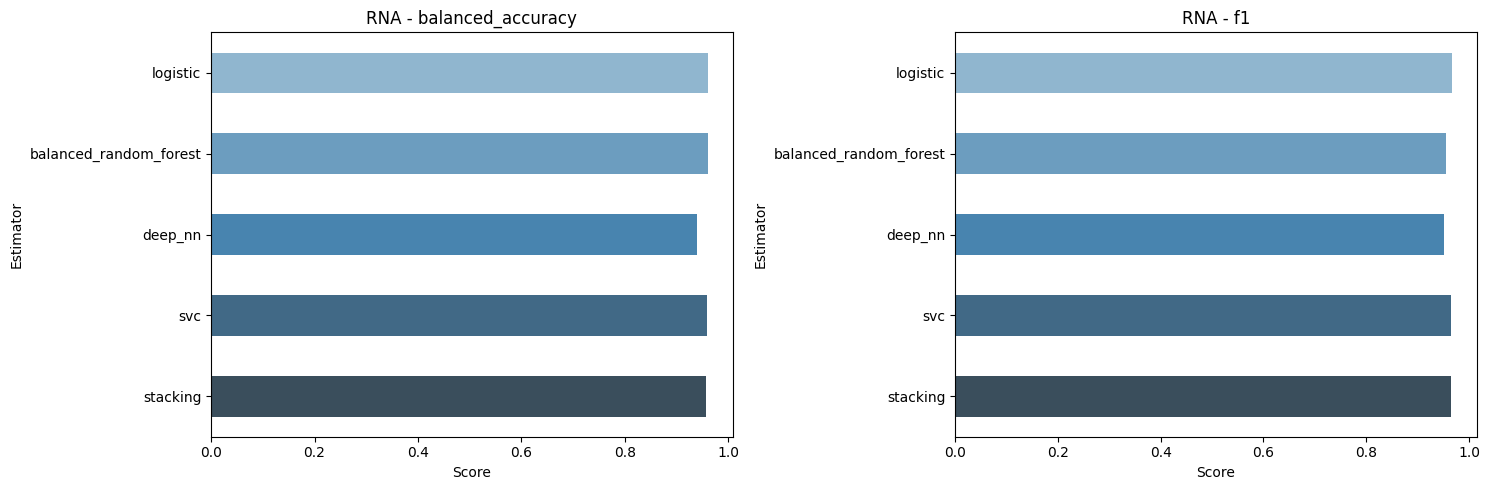

In [ ]:
plot_bar_scores(estimator_names, all_scores['rna'].values(), 'RNA', metrics=['balanced_accuracy', 'f1'])

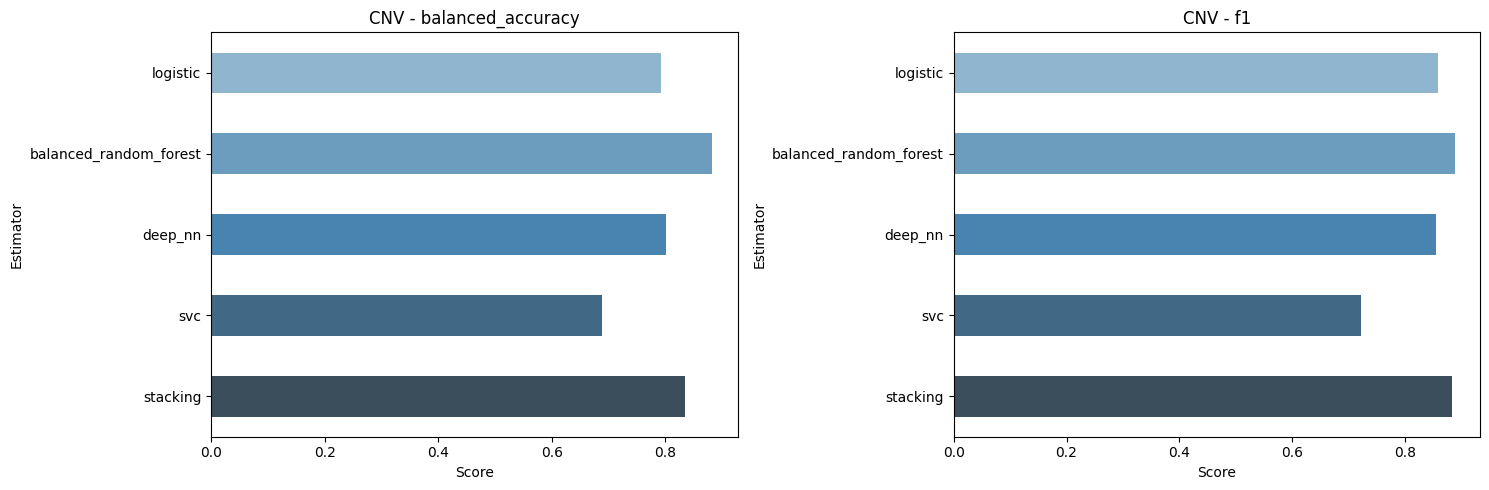

In [ ]:
plot_bar_scores(estimator_names, all_scores['cnv'].values(), 'CNV', metrics=['balanced_accuracy', 'f1'])

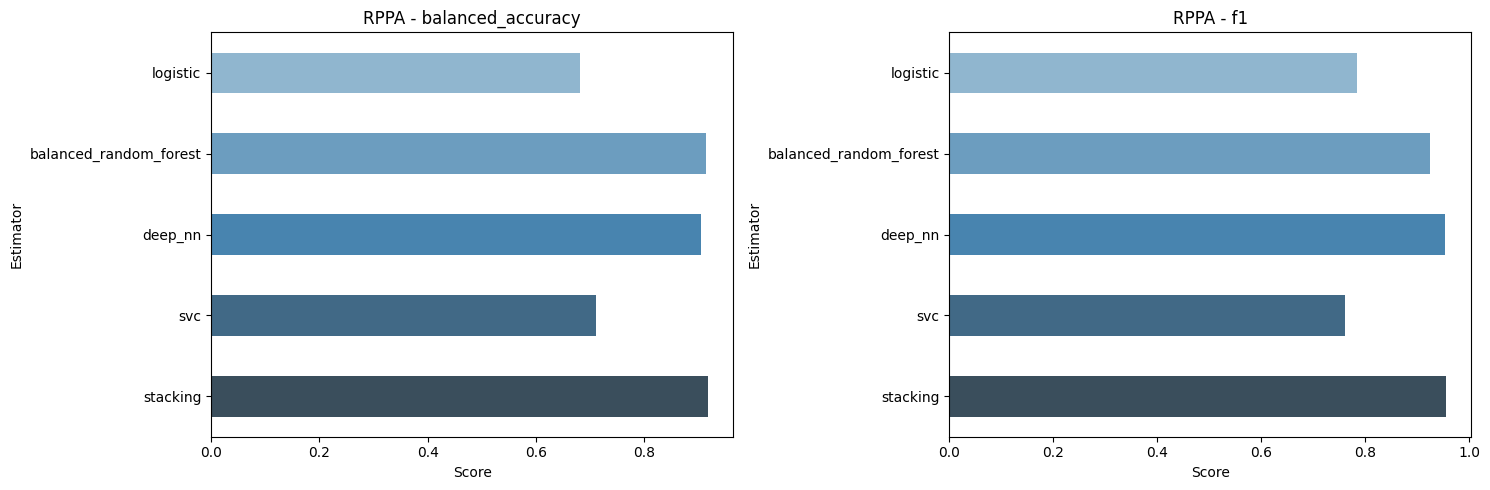

In [ ]:
plot_bar_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  


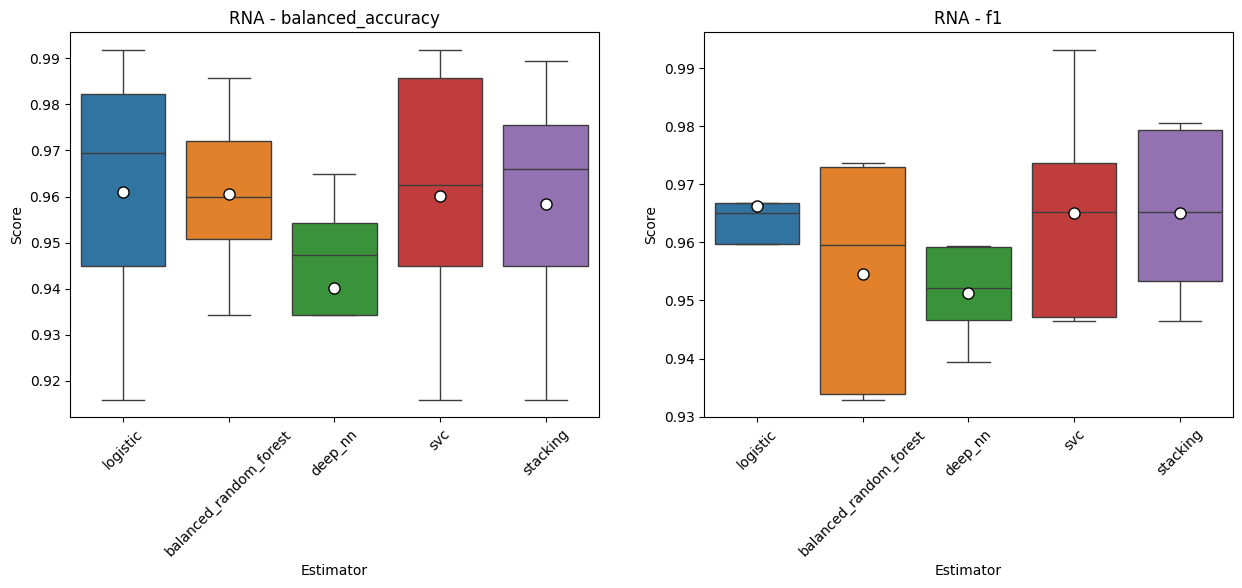

In [ ]:
plot_box_scores(estimator_names, all_scores['rna'].values(), 'RNA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  


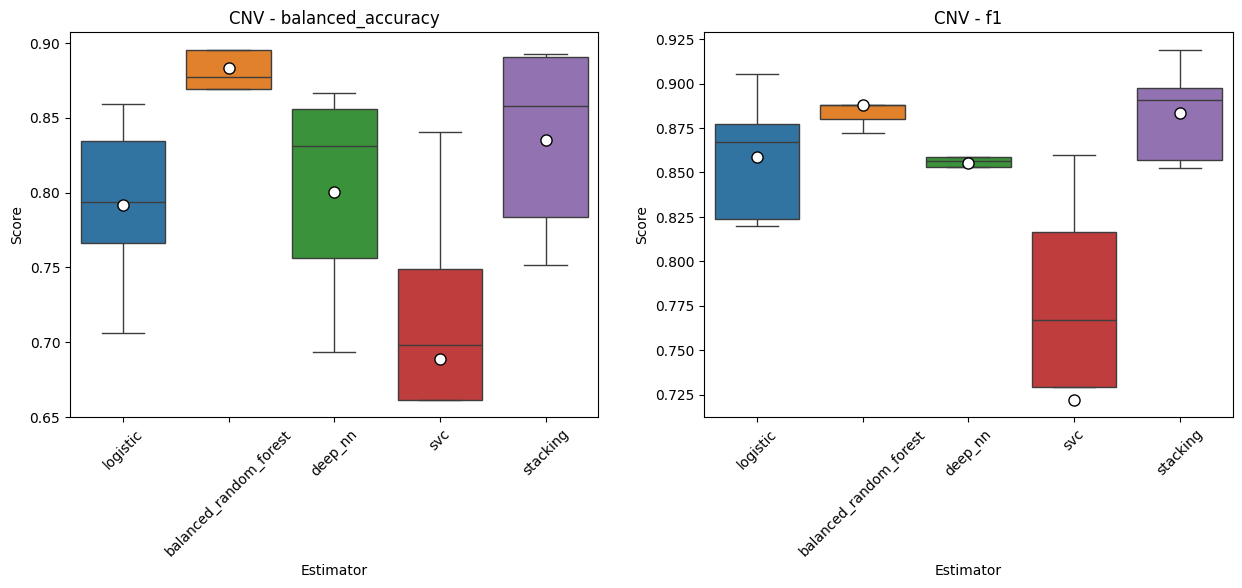

In [ ]:
plot_box_scores(estimator_names, all_scores['cnv'].values(), 'CNV', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  


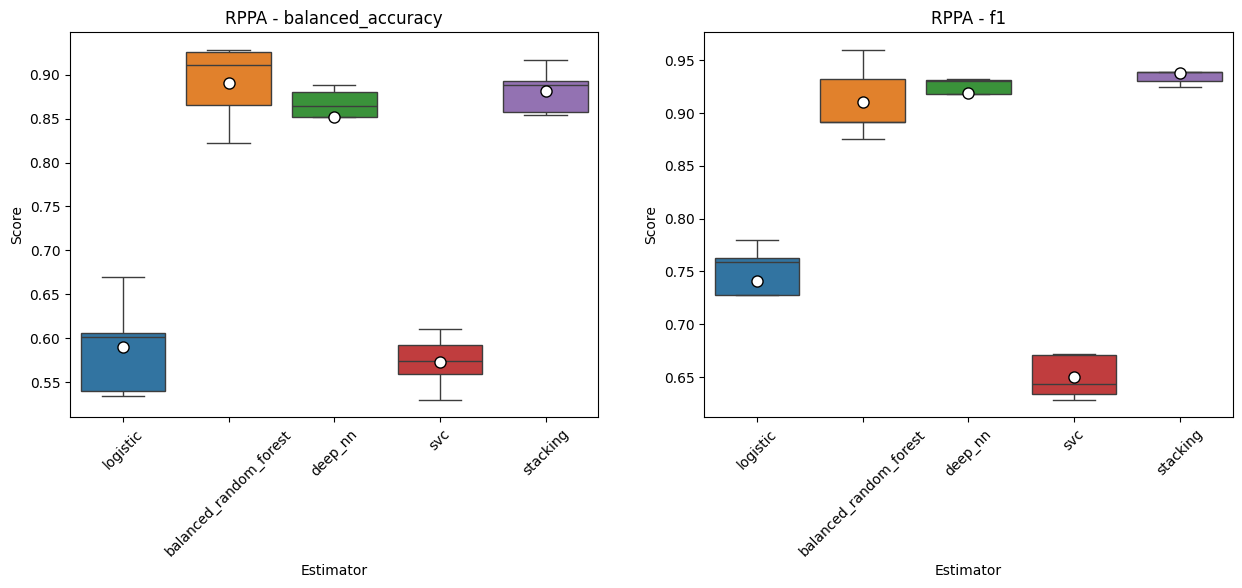

In [ ]:
plot_box_scores(estimator_names, all_scores['rppa'].values(), 'RPPA', metrics=['balanced_accuracy', 'f1'])

## Multi Omics Integration Ensemble

### Cross Val Predict

In [ ]:
preds = {}

skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

for modality in tqdm(datasets):
    preds[modality] = cross_val_predict(classifiers[modality], X[modality], y, cv=skf, n_jobs=-1, method ='predict_proba')

In [ ]:
# Making dataframe of predicted class out of probabilities
preds_class_df = pd.DataFrame({
    'rna': preds['rna'].argmax(axis=1),
    'cnv': preds['cnv'].argmax(axis=1),
    'rppa': preds['rppa'].argmax(axis=1)
})

# Making dataframe of predicted probabilities
preds_proba_df = pd.concat([pd.DataFrame(preds['rna'], columns=['rna_KICH', 'rna_KIRC', 'rna_KIRP']), pd.DataFrame(preds['cnv'], columns=['cnv_KICH', 'cnv_KIRC', 'cnv_KIRP']), pd.DataFrame(preds['rppa'], columns=['rppa_KICH', 'rppa_KIRC', 'rppa_KIRP'])], axis=1)

In [ ]:
preds_class_df

,rna,cnv,rppa
0,0,0,0
1,0,0,0
2,0,2,0
3,0,0,0
4,0,0,1
...,...,...,...
740,2,2,2
741,2,2,2
742,2,1,2
743,2,2,2


In [ ]:
preds_proba_df

,rna_KICH,rna_KIRC,rna_KIRP,cnv_KICH,cnv_KIRC,cnv_KIRP,rppa_KICH,rppa_KIRC,rppa_KIRP
0,0.915607,0.045604,0.038789,0.898000,0.076016,0.025984,0.664656,0.089507,0.245838
1,0.862500,0.129541,0.007958,0.909660,0.066129,0.024211,0.927931,0.022498,0.049571
2,0.937118,0.030343,0.032540,0.089807,0.317458,0.592735,0.972242,0.021291,0.006467
3,0.849237,0.139902,0.010861,0.602241,0.310769,0.086990,0.895499,0.060093,0.044409
4,0.935229,0.026760,0.038010,0.955289,0.034666,0.010045,0.283692,0.399620,0.316688
...,...,...,...,...,...,...,...,...,...
740,0.004060,0.020598,0.975342,0.048437,0.222579,0.728984,0.007751,0.012599,0.979650
741,0.003511,0.014863,0.981625,0.007451,0.031505,0.961043,0.010171,0.020882,0.968948
742,0.008283,0.026506,0.965211,0.014118,0.946792,0.039090,0.283740,0.030794,0.685466
743,0.006007,0.021183,0.972810,0.008341,0.027612,0.964047,0.004768,0.004171,0.991062


With Voting:

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

# Find the majority class for each sample
majority_class = pred_df.mode(axis=1)[0]

# Calculate the scores
accuracy = accuracy_score(y, majority_class)
f1 = f1_score(y, majority_class, average='weighted')
recall = recall_score(y, majority_class, average=None)

scores_df = pd.DataFrame({'accuracy': [accuracy], 'f1': [f1], 'recall (KICH)': [recall[0]], 'recall (KIRC)': [recall[1]], 'recall (KIRP)': [recall[2]]})

# Combine scores_df with modality_metrics
integration_voting_metrics = pd.concat([modality_metrics, scores_df.rename(index={0: 'majority_class'})])

integration_voting_metrics


,accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna,0.968 +/- 0.018,0.968 +/- 0.018,0.954 +/- 0.092,0.968 +/- 0.025,0.972 +/- 0.023
cnv,0.882 +/- 0.034,0.881 +/- 0.033,0.732 +/- 0.112,0.925 +/- 0.041,0.831 +/- 0.053
rppa,0.945 +/- 0.027,0.943 +/- 0.028,0.733 +/- 0.086,0.985 +/- 0.009,0.920 +/- 0.072
majority_class,0.969128,0.969151,0.936508,0.976546,0.962441


With Stacking:

In [ ]:
integration_scores, integration_metrics = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_class_df, y, name='Integration Model', cv=5, verbose=2, scoring={"accuracy": "accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)})

In [ ]:
integration_metrics

,accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
Integration Model,0.961 +/- 0.026,0.961 +/- 0.027,0.892 +/- 0.115,0.979 +/- 0.018,0.944 +/- 0.036


In [ ]:
names = ['cnv', 'rna', 'rppa', 'integration']
integration = []
integration.append(scores['cnv'])
integration.append(scores['rna'])
integration.append(scores['rppa'])
integration.append(integration_scores)

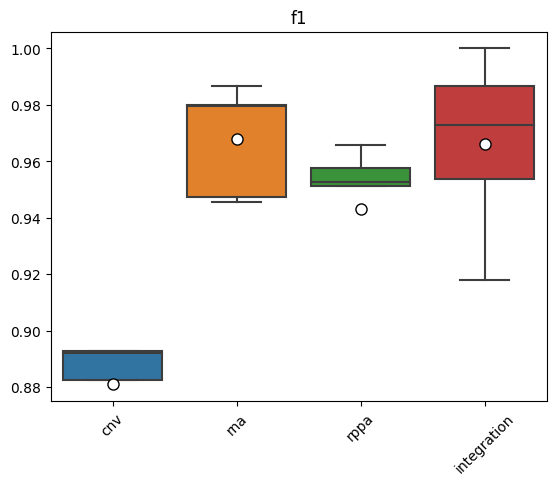

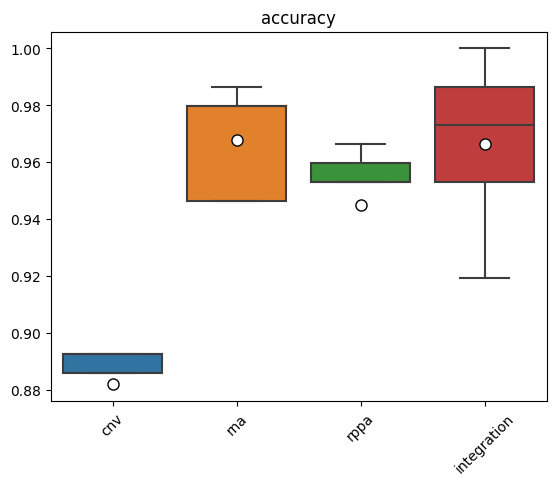

In [ ]:
plot_scores(names, integration)

In [ ]:
rna_cnv_rppa_scores, rna_cnv_rppa_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df, y, name='rna + cnv + rppa', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)})
cnv_rppa_scores, cnv_rppa_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df[['cnv_KICH', 'cnv_KIRC', 'cnv_KIRP', 'rppa_KICH', 'rppa_KIRC', 'rppa_KIRP']], y, name='cnv + rppa', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)})
rna_rppa_scores, rna_rppa_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df[['rna_KICH', 'rna_KIRC', 'rna_KIRP', 'rppa_KICH', 'rppa_KIRC', 'rppa_KIRP']], y, name='rna + rppa', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)})
rna_cnv_scores, rna_cnv_df = get_cross_metrics(LogisticRegression(random_state=0, n_jobs=1), preds_proba_df[['rna_KICH', 'rna_KIRC', 'rna_KIRP', 'cnv_KICH', 'cnv_KIRC', 'cnv_KIRP']], y, name='rna + cnv', cv=5, verbose=2, scoring={"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)})

In [ ]:
integration_stacking_metrics = pd.concat([modality_metrics, rna_cnv_rppa_df, cnv_rppa_df, rna_rppa_df, rna_cnv_df])

In [ ]:
integration_stacking_metrics

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna,0.968 +/- 0.018,0.960 +/- 0.037,0.968 +/- 0.018,0.938 +/- 0.090,0.970 +/- 0.018,0.972 +/- 0.018
cnv,0.893 +/- 0.029,0.851 +/- 0.060,0.892 +/- 0.030,0.781 +/- 0.147,0.932 +/- 0.023,0.841 +/- 0.056
rppa,0.936 +/- 0.026,0.883 +/- 0.051,0.934 +/- 0.028,0.781 +/- 0.099,0.977 +/- 0.008,0.891 +/- 0.064
rna + cnv + rppa,0.976 +/- 0.021,0.961 +/- 0.036,0.976 +/- 0.021,0.923 +/- 0.084,0.983 +/- 0.017,0.976 +/- 0.015
cnv + rppa,0.966 +/- 0.014,0.934 +/- 0.038,0.966 +/- 0.015,0.860 +/- 0.101,0.985 +/- 0.011,0.958 +/- 0.023
rna + rppa,0.976 +/- 0.016,0.961 +/- 0.034,0.976 +/- 0.016,0.923 +/- 0.084,0.983 +/- 0.014,0.977 +/- 0.021
rna + cnv,0.968 +/- 0.018,0.959 +/- 0.036,0.968 +/- 0.018,0.938 +/- 0.090,0.972 +/- 0.020,0.967 +/- 0.024


In [ ]:
names = ['rna', 'cnv', 'rppa', 'rna + cnv + rppa', 'cnv + rppa', 'rna + rppa', 'rna + cnv']
integration = []
integration.append(scores['rna'])
integration.append(scores['cnv'])
integration.append(scores['rppa'])
integration.append(rna_cnv_rppa_scores)
integration.append(cnv_rppa_scores)
integration.append(rna_rppa_scores)
integration.append(rna_cnv_scores)

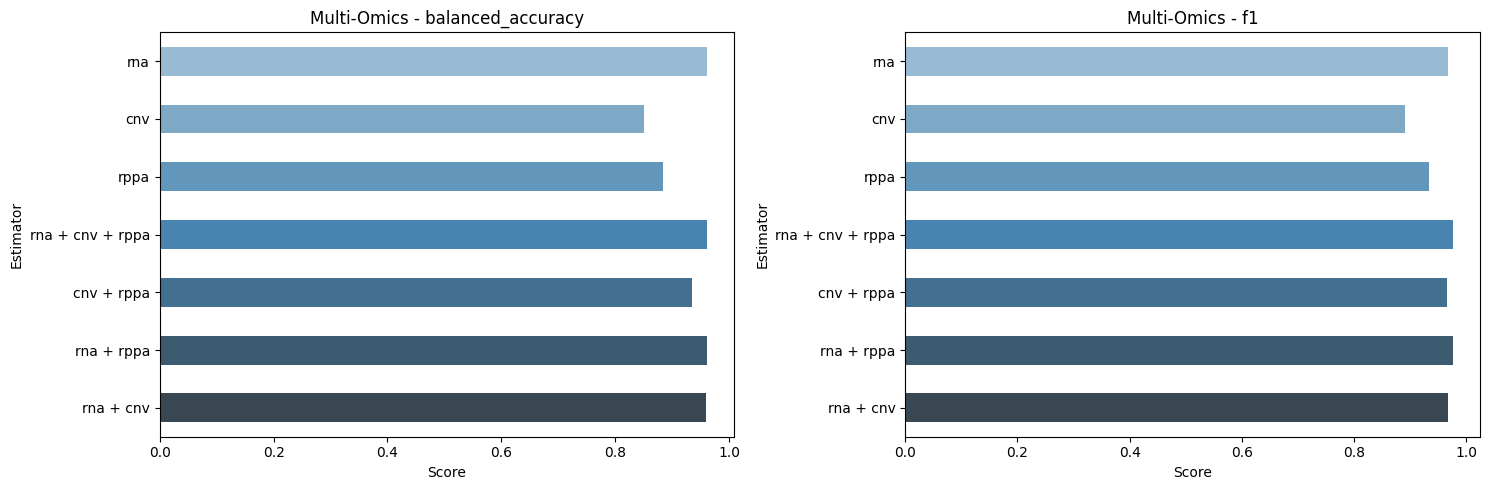

In [ ]:
plot_bar_scores(names, integration, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

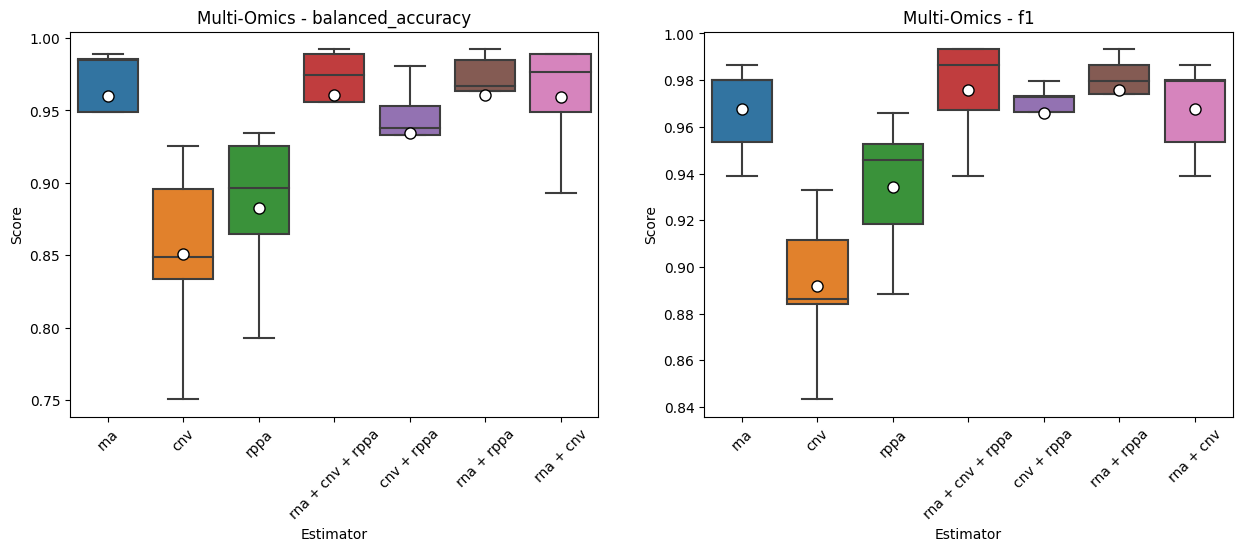

In [ ]:
plot_box_scores(names, integration, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

### Ensemble Model as a Custom Classifier

In [ ]:
column_names = {}

for key in X.keys():
    column_names[key] = X[key].columns

In [ ]:
meta_ensembles = {}
meta_ensembles['rna + cnv + rppa'] = MultiOmicsIntegrationClassifier(classifiers, cv=3)
meta_ensembles['cnv + rppa'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['cnv', 'rppa']}, cv=3)
meta_ensembles['rna + cnv'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['rna', 'cnv']}, cv=3)
meta_ensembles['rna + rppa'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['rna', 'rppa']}, cv=3)

In [ ]:
X_merged = {}
X_merged['rna + cnv + rppa'] = pd.concat([X['rna'], X['cnv'], X['rppa']], axis=1, join='inner')
X_merged['cnv + rppa'] = pd.concat([X['cnv'], X['rppa']], axis=1, join='inner')
X_merged['rna + cnv'] = pd.concat([X['rna'], X['cnv']], axis=1, join='inner')
X_merged['rna + rppa'] = pd.concat([X['rna'], X['rppa']], axis=1, join='inner')


In [ ]:
integration_scores = {}
integration_metrics = {}

In [ ]:
integration_scores['rna + cnv + rppa'], integration_metrics['rna + cnv + rppa'] = get_cross_metrics(meta_ensembles['rna + cnv + rppa'], X_merged['rna + cnv + rppa'], y, name='rna + cnv + rppa', cv=5, verbose=2, scoring=kipan_scoring, fit_params={'column_names': column_names})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 45.5min finished


In [ ]:
integration_metrics['rna + cnv + rppa']

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna + cnv + rppa,0.976 +/- 0.012,0.967 +/- 0.027,0.976 +/- 0.012,0.938 +/- 0.090,0.976 +/- 0.023,0.985 +/- 0.020


In [ ]:
integration_scores['cnv + rppa'], integration_metrics['cnv + rppa'] = get_cross_metrics(meta_ensembles['cnv + rppa'], X_merged['cnv + rppa'], y, name='cnv + rppa', cv=5, verbose=2, scoring=kipan_scoring, fit_params={'column_names': column_names})

In [ ]:
integration_scores['rna + rppa'], integration_metrics['rna + rppa'] = get_cross_metrics(meta_ensembles['rna + rppa'], X_merged['rna + rppa'], y, name='rna + rppa', cv=5, verbose=2, scoring=kipan_scoring, fit_params={'column_names': column_names})

In [ ]:
integration_scores['rna + cnv'], integration_metrics['rna + cnv'] = get_cross_metrics(meta_ensembles['rna + cnv'], X_merged['rna + cnv'], y, name='rna + cnv', cv=5, verbose=2, scoring=kipan_scoring, fit_params={'column_names': column_names})

In [ ]:
all_integration_metrics = pd.concat([modality_metrics, pd.concat([x for x in integration_metrics.values()])])
names = ['rna', 'cnv', 'rppa', 'rna + cnv + rppa', 'cnv + rppa', 'rna + rppa', 'rna + cnv']

all_integration_scores = scores

# Adding multi-omic ensemble scores
for name, value in integration_scores.items():
    all_integration_scores[name] = value

In [ ]:
all_integration_metrics

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna,0.965 +/- 0.014,0.958 +/- 0.026,0.965 +/- 0.014,0.938 +/- 0.090,0.966 +/- 0.023,0.971 +/- 0.028
cnv,0.885 +/- 0.024,0.835 +/- 0.057,0.883 +/- 0.025,0.749 +/- 0.146,0.927 +/- 0.013,0.830 +/- 0.041
rppa,0.939 +/- 0.011,0.882 +/- 0.023,0.938 +/- 0.011,0.764 +/- 0.082,0.979 +/- 0.012,0.903 +/- 0.027
rna + cnv + rppa,0.976 +/- 0.012,0.967 +/- 0.027,0.976 +/- 0.012,0.938 +/- 0.090,0.976 +/- 0.023,0.985 +/- 0.020


In [ ]:
# Convert and write JSON object to file
with open("results/kipan/subtyping/kipan_multi_omics_results.json", "w") as outfile:
    json.dump(integration_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

In [ ]:
# Convert and write JSON object to file
with open("results/kipan/subtyping/kipan_modality_multi_omics_results.json", "w") as outfile:
    json.dump(all_integration_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

In [ ]:
all_integration_metrics

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna,0.965 +/- 0.014,0.958 +/- 0.026,0.965 +/- 0.014,0.938 +/- 0.090,0.966 +/- 0.023,0.971 +/- 0.028
cnv,0.885 +/- 0.024,0.835 +/- 0.057,0.883 +/- 0.025,0.749 +/- 0.146,0.927 +/- 0.013,0.830 +/- 0.041
rppa,0.939 +/- 0.011,0.882 +/- 0.023,0.938 +/- 0.011,0.764 +/- 0.082,0.979 +/- 0.012,0.903 +/- 0.027
rna + cnv + rppa,0.976 +/- 0.012,0.967 +/- 0.027,0.976 +/- 0.012,0.938 +/- 0.090,0.976 +/- 0.023,0.985 +/- 0.020


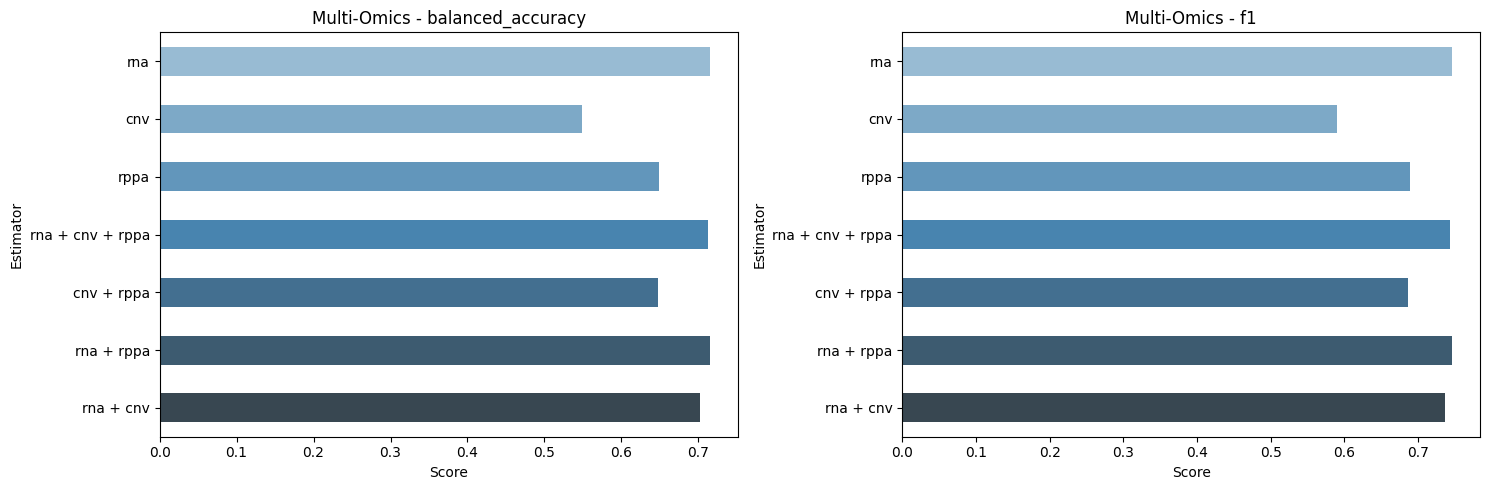

In [ ]:
plot_bar_scores(names, all_integration_scores, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

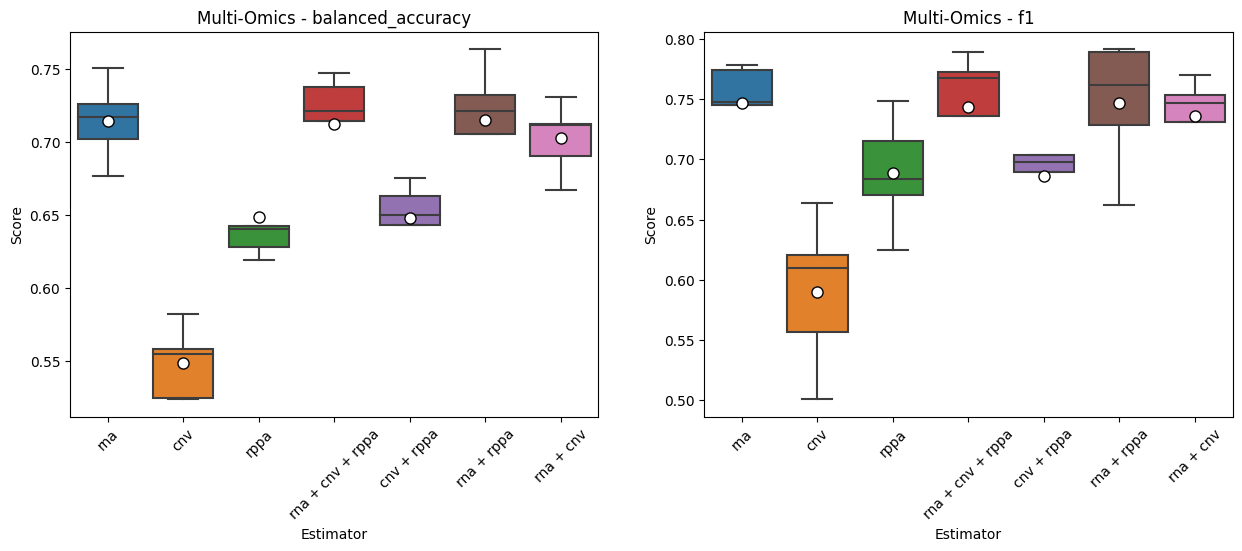

In [ ]:
plot_box_scores(names, all_integration_scores, 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

## Statistical Significance

Now that we see the results, we want to check if the performance differences between our multi-omics ensemble models and the modality ensemble models are significant. We can employ the Wilcoxen test, using multiple replications of cross-validation to get scores.

### Wilcoxen

In [ ]:
ensemble_results = {}
ensemble_metrics = {}

In [ ]:
def wilcoxen_test(name_1, name_2, scores_1, scores_2):

    stat, p = wilcoxon(scores_1, scores_2, alternative='greater')

    df = pd.Series({'estimator_1': name_1, 'estimator_2': name_2, 'statistic': stat, 'p': p, 'significant': p <= 0.05})

    return pd.DataFrame(df).T

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
ensemble_results['cnv + rppa'], ensemble_metrics['cnv + rppa'] = get_cross_metrics(meta_ensembles['cnv + rppa'], X_merged['cnv + rppa'], y, name='cnv + rppa', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_scoring, fit_params={'column_names': {key: column_names[key] for key in ['cnv', 'rppa']}})
ensemble_results['rppa'], ensemble_metrics['rppa'] = get_cross_metrics(classifiers['rppa'], X['rppa'], y, name='rppa', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_scoring)


In [ ]:
ensemble_results['rna + rppa'], ensemble_metrics['rna + rppa'] = get_cross_metrics(meta_ensembles['rna + rppa'], X_merged['rna + rppa'], y, name='rna + rppa', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'rppa']}})
ensemble_results['rna'], ensemble_metrics['rna'] = get_cross_metrics(classifiers['rna'], X['rna'], y, name='rna', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_scoring)

hello
hello


In [ ]:
# Picking models we want to compare performances for
compare = [
    ('cnv + rppa', 'rppa'),
    ('rna + rppa', 'rna')
]

In [ ]:
from scipy.stats import wilcoxon

wilcoxen_results = {}
metrics = ['balanced_accuracy', 'f1']

for metric in metrics:
    wilcoxen_results[metric] = pd.DataFrame()
    for est1, est2 in compare:
        df = wilcoxen_test(est1, est2, ensemble_results[est1]['test_' + metric], ensemble_results[est2]['test_' + metric])
        wilcoxen_results[metric] = pd.concat([wilcoxen_results[metric], df])


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [ ]:
display(wilcoxen_results['balanced_accuracy'], wilcoxen_results['f1'])

,estimator_1,estimator_2,statistic,p,significant
0,cnv + rppa,rppa,119.0,0.000061,True
0,rna + rppa,rna,78.0,0.001109,True


,estimator_1,estimator_2,statistic,p,significant
0,cnv + rppa,rppa,120.0,0.000031,True
0,rna + rppa,rna,104.0,0.000613,True


/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  


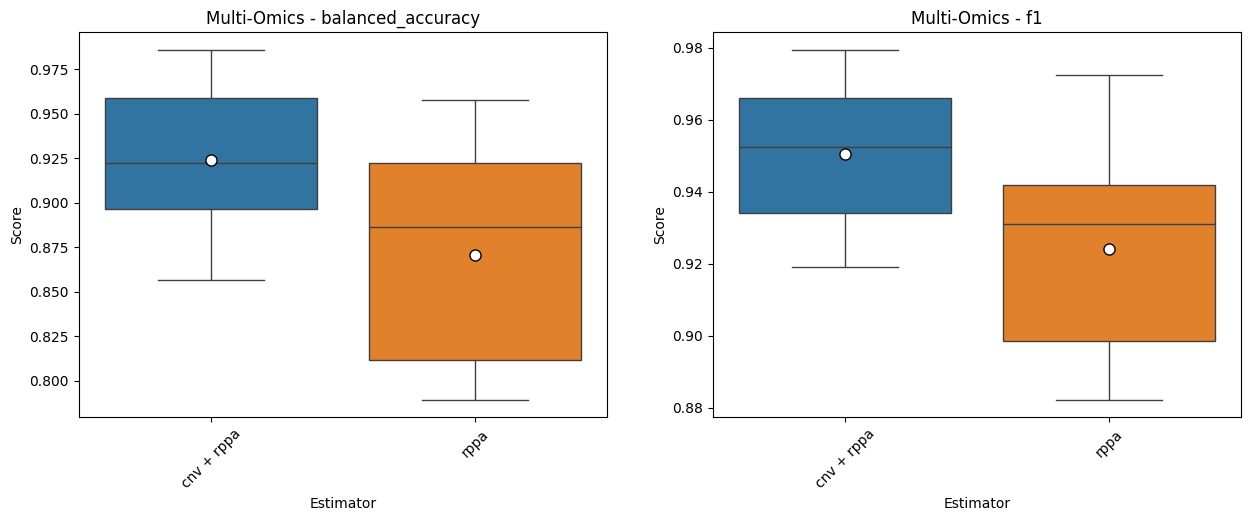

In [ ]:
plot_box_scores(['cnv + rppa', 'rppa'], [ensemble_results['cnv + rppa'], ensemble_results['rppa']], 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

In [ ]:
plot_box_scores(['rna + rppa', 'rna'], [ensemble_results['rna + rppa'], ensemble_results['rna']], 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

In [ ]:
# Convert and write JSON object to file
with open("results/kipan/subtyping/kipan_5x3_results.json", "w") as outfile:
    json.dump(ensemble_results, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

## Feature Importance

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [ ]:
# Splitting into training, validation
X_train, X_test, y_train, y_test = train_test_split(X['cnv'], y, random_state=0, stratify=y)

In [ ]:
# Fitting on training data
classifiers['cnv'].fit(X_train, y_train)

ModalityPipeline(cv=3,
                 estimator_list=[('logistic',
                                  Pipeline(steps=[('standardscaler',
                                                   StandardScaler()),
                                                  ('logisticregression',
                                                   LogisticRegression(max_iter=1000,
                                                                      n_jobs=-1,
                                                                      random_state=0))])),
                                 ('balanced_random_forest',
                                  BalancedRandomForestClassifier(n_jobs=-1,
                                                                 random_state=0,
                                                                 replacement=True,
                                                                 sampling_strategy='all')),
                                 ('deep_nn',
                                  Pipeline(steps=[('standardscaler',
                                                   StandardScaler()),
                                                  ('mlpclassifier',
                                                   MLPClassifier(random_state=0))])),
                                 ('svc',
                                  Pipeline(steps=[('standardscaler',
                                                   StandardScaler()),
                                                  ('svc',
                                                   SVC(kernel='linear',
                                                       max_iter=1000,
                                                       random_state=0))]))])

In [ ]:
# Getting baseline scores
baseline_scores = {}
for name, scorer in kipan_scoring.items():
  #y_preds = meta_ensembles['rna + rppa'].predict(X_test)
  baseline_scores[name] = get_scorer(scorer)(classifiers['cnv'], X_test, y_test)

In [ ]:
print(baseline_scores)

{'accuracy': 0.9347826086956522, 'balanced_accuracy': 0.8542190380425675, 'f1': 0.932227796358231, 'recall (KICH)': 0.625, 'recall (KIRC)': 0.9572649572649573, 'recall (KIRP)': 0.9803921568627451}


In [ ]:
r = permutation_importance(classifiers['cnv'], X_test, y_test, n_repeats=2, random_state=0, scoring=kipan_scoring, n_jobs=-1)

In [ ]:
X['cnv']

,2_RPPA,3_RPPA,5_RPPA,7_RPPA,8_RPPA,9_RPPA,12_RPPA,13_RPPA,14_RPPA,15_RPPA,...,154_RPPA,155_RPPA,156_RPPA,161_RPPA,162_RPPA,163_RPPA,168_RPPA,170_RPPA,171_RPPA,173_RPPA
0,0.3250,0.0333,-0.2436,0.4768,-0.0460,0.3250,0.0363,-1.0965,0.6190,0.3250,...,0.2213,-1.2837,-1.1059,-0.7048,-0.1218,-0.3658,0.0333,-0.7856,0.3250,0.3380
1,-0.2881,-0.0535,0.3487,0.0772,0.0267,-0.2881,0.1997,0.5603,0.1687,-0.2881,...,-0.1230,0.3182,0.3433,0.0278,0.1036,0.0491,-0.0535,0.4836,-0.2881,0.0768
2,-0.1989,-0.1168,-0.2557,0.1963,-0.0292,-0.1989,-0.4118,-0.0345,0.0579,-0.1989,...,0.1500,0.2389,0.3029,0.2332,0.3082,0.1375,-0.1168,0.1165,-0.1989,-0.2101
3,-0.3845,-0.2633,0.3273,0.0554,-0.0830,-0.3845,0.0906,-0.1448,0.4268,-0.3845,...,-0.0179,0.1885,0.2492,0.1491,0.0930,0.0001,-0.2633,0.0671,-0.3845,-0.2063
4,0.1084,0.2461,0.1255,0.7019,-0.0958,0.1084,0.3693,0.5226,0.1916,0.1084,...,0.4595,-0.5655,-0.4481,-0.4094,0.1086,-0.1831,0.2461,-0.4155,0.1084,0.1609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731,0.0376,0.3055,0.6506,-0.0004,-0.2889,0.0376,-0.3222,0.0503,-0.5031,0.0376,...,0.0208,0.9498,0.2427,0.3008,0.6645,0.0649,0.3055,0.1911,0.0376,0.8432
732,0.4850,-0.3982,0.1483,0.0134,-0.0029,0.4850,0.4479,-1.7764,0.6475,0.4850,...,0.6610,0.3376,0.4758,-0.0406,-0.0813,-0.1843,-0.3982,0.0256,0.4850,0.6426
733,-0.2562,-0.0964,0.4708,0.5299,-0.2983,-0.2562,0.1949,0.9751,0.6406,-0.2562,...,0.1545,-0.1540,-0.3098,-0.3229,0.4338,0.3626,-0.0964,0.1604,-0.2562,-0.2847
734,0.0109,-0.1186,0.2317,-0.2340,-0.4800,0.0109,0.3446,0.0496,1.4964,0.0109,...,0.4606,-0.2124,-0.3112,0.5895,0.0486,0.0118,-0.1186,-0.0956,0.0109,1.1134


In [ ]:
for i in r['balanced_accuracy'].importances_mean.argsort()[::-1]:
     if r['balanced_accuracy'].importances_mean[i] - 2 * r['balanced_accuracy'].importances_std[i] > 0:
         print(f"{X['rppa'].columns[i]:<8}"
               f"{r['balanced_accuracy'].importances_mean[i]:.3f}"
               f" +/- {r['balanced_accuracy'].importances_std[i]:.3f}")

43_RPPA 0.058 +/- 0.027
59_RPPA 0.033 +/- 0.006
35_RPPA 0.029 +/- 0.001
42_RPPA 0.024 +/- 0.003
17_RPPA 0.024 +/- 0.003
7_RPPA  0.022 +/- 0.009
115_RPPA0.022 +/- 0.003
76_RPPA 0.021 +/- 0.002
163_RPPA0.020 +/- 0.007
168_RPPA0.020 +/- 0.009
119_RPPA0.019 +/- 0.006
24_RPPA 0.018 +/- 0.000
151_RPPA0.017 +/- 0.007
131_RPPA0.014 +/- 0.001
45_RPPA 0.013 +/- 0.000
173_RPPA0.013 +/- 0.003
118_RPPA0.010 +/- 0.001
129_RPPA0.010 +/- 0.003
3_RPPA  0.008 +/- 0.002
8_RPPA  0.007 +/- 0.000
149_RPPA0.005 +/- 0.001
138_RPPA0.005 +/- 0.001
136_RPPA0.003 +/- 0.000


In [ ]:
r['balanced_accuracy'].importances_mean.argsort()[::-1]

array([2179, 2501, 2148, ..., 2952, 3336, 2910])

In [ ]:
r['balanced_accuracy'].importances_mean

array([-0.0014245,  0.       , -0.0014245, ..., -0.002849 , -0.0014245,
       -0.002849 ])

In [ ]:
print("Top 20 features")

for i in r['balanced_accuracy'].importances_mean.argsort()[:20]:
  if r['balanced_accuracy'].importances_mean[i] - 2 * r['balanced_accuracy'].importances_std[i] < 0:
     print(f"{X['cnv'].columns[i]:<8}: "
               f"{r['balanced_accuracy'].importances_mean[i]:.3f}"
               f" +/- {r['balanced_accuracy'].importances_std[i]:.3f}")


Top 20 features
CSMD1_cnv: -0.011 +/- 0.005
E2F4_cnv: -0.008 +/- 0.001
NACAP1_cnv: -0.008 +/- 0.001
PRKAR2B_cnv: -0.007 +/- 0.000
FGD5_cnv: -0.007 +/- 0.000
KCNK5_cnv: -0.007 +/- 0.000
WIPF3_cnv: -0.007 +/- 0.000
SNORA31|ENSG00000253028.1_cnv: -0.007 +/- 0.000
FAR2_cnv: -0.007 +/- 0.000
TSPAN9_cnv: -0.007 +/- 0.000
WDR60_cnv: -0.007 +/- 0.000
COLQ_cnv: -0.007 +/- 0.000
RAD52_cnv: -0.007 +/- 0.000
TNFAIP8_cnv: -0.007 +/- 0.000
TRIM4_cnv: -0.007 +/- 0.000
MYOT_cnv: -0.007 +/- 0.000
ZFYVE20_cnv: -0.007 +/- 0.000
CAPN7_cnv: -0.007 +/- 0.000
MIR4647_cnv: -0.007 +/- 0.000
ARHGEF35_cnv: -0.007 +/- 0.000


# Subtyping (RNA, CNV, RPPA) - Feature Selection

In [4]:
datasets = {
            'rna': '../data/kipan/subtyping/RNASeq.csv',
            'cnv': '../data/kipan/subtyping/CNV.csv',
            'rppa': '../data/kipan/subtyping/RPPA.csv',
}

labels = '../data/kipan/subtyping/Clinical.csv'

In [5]:
subtypes = pd.read_csv(labels, index_col=0)
data = {}

for modality in datasets:
    data[modality] = pd.read_csv(datasets[modality], index_col=0)
    print(modality, data[modality].shape)

rna (736, 20190)
cnv (736, 24776)
rppa (736, 202)


## Preprocessing

### Removing low-variance + null features

In [6]:
!pip3 install scanpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 7.6 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=98a5de01f270748046f34997d6be67914f6971dd565cb143338677c7dc7318bc
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [7]:
import scanpy as sc
from scanpy.pp import highly_variable_genes
import anndata as an

In [8]:
adata = {}

for modality in datasets:
  data[modality] = data[modality].dropna(axis=1)
  adata[modality] = an.AnnData(data[modality])

In [9]:
sc.pp.highly_variable_genes(adata['rna'], n_top_genes=1000)

In [10]:
sc.pp.highly_variable_genes(adata['cnv'], n_top_genes=1000)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:276: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


In [11]:
sc.pp.highly_variable_genes(adata['rppa'], n_top_genes=1000)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:276: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:383: UserWarning: `n_top_genes` > number of normalized dispersions, returning all genes with normalized dispersions.
  warnings.warn(msg, UserWarning)


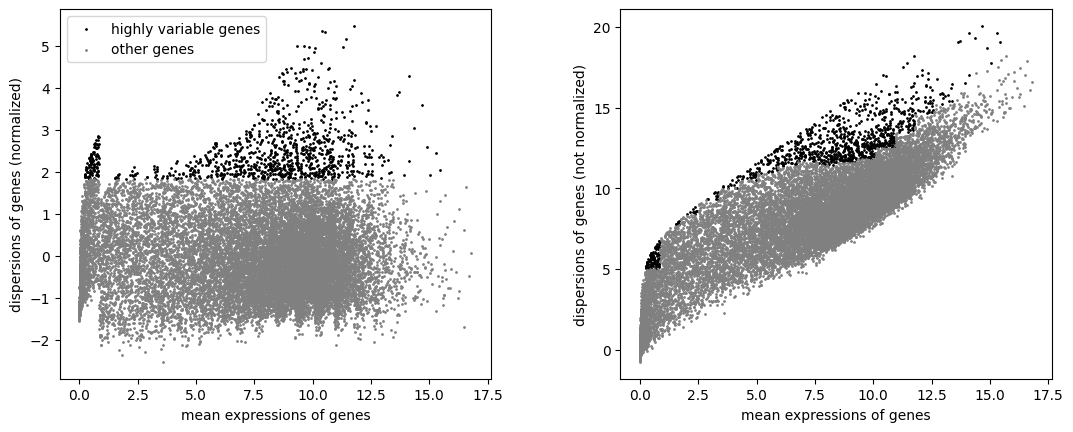

In [12]:
sc.pl.highly_variable_genes(adata['rna'])

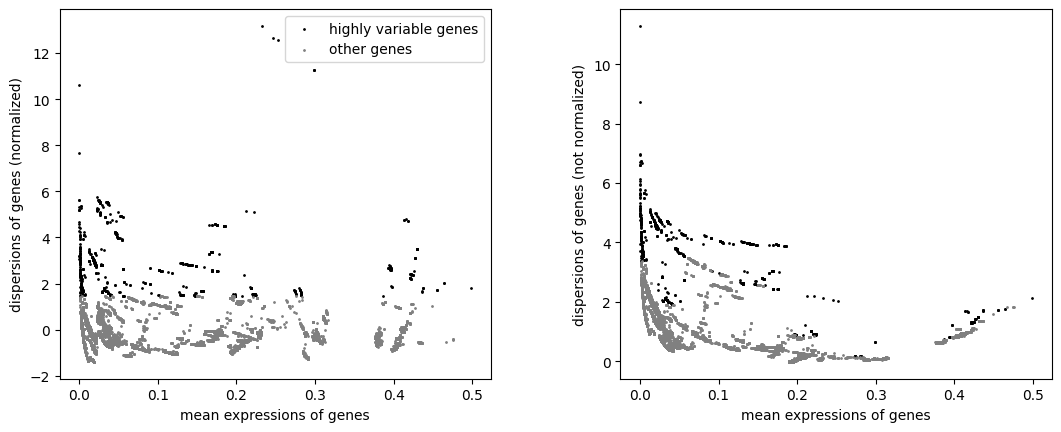

In [13]:
sc.pl.highly_variable_genes(adata['cnv'])

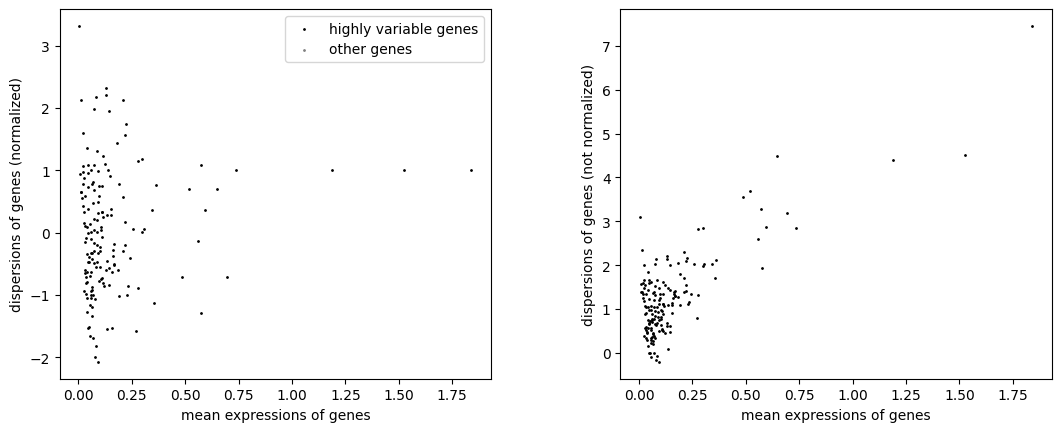

In [14]:
sc.pl.highly_variable_genes(adata['rppa'])

In [15]:
adata_new = {}

for modality in datasets:
  adata_new[modality] = adata[modality][:, adata[modality].var.highly_variable]
  sc.pp.scale(adata_new[modality], max_value=10)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:299: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [16]:
adata_new

{'rna': AnnData object with n_obs × n_vars = 736 × 1000
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'hvg',
 'cnv': AnnData object with n_obs × n_vars = 736 × 1000
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'hvg',
 'rppa': AnnData object with n_obs × n_vars = 736 × 168
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
     uns: 'hvg'}

In [17]:
import pandas as pd

X = {}

# Convert numpy array to DataFrame
for modality in adata_new:
    X[modality] = adata_new[modality].to_df()
    print(modality, X[modality].shape)

rna (736, 1000)
cnv (736, 1000)
rppa (736, 168)


In [18]:
subtypes['histological_type'].value_counts()

histological_type
kidneyclearcellrenalcarcinoma        467
kidneypapillaryrenalcellcarcinoma    206
kidneychromophobe                     63
Name: count, dtype: int64

In [19]:
enc = LabelEncoder()
y = enc.fit_transform(subtypes['histological_type'])
enc.inverse_transform([0, 1, 2])

array(['kidneychromophobe', 'kidneyclearcellrenalcarcinoma',
       'kidneypapillaryrenalcellcarcinoma'], dtype=object)

## Base Learners

In [20]:
from imblearn.ensemble import BalancedRandomForestClassifier

estimators = [
    ("logistic", make_pipeline(StandardScaler(), LogisticRegression(random_state=0, max_iter=1000, n_jobs=-1))),
    ("balanced_random_forest", BalancedRandomForestClassifier(random_state=0, n_jobs=-1, sampling_strategy='all', replacement=True)),
    ("deep_nn", make_pipeline(StandardScaler(), MLPClassifier(random_state=0))),
    ("svc", make_pipeline(StandardScaler(), SVC(random_state=0, kernel='linear', max_iter=1000)))
]

estimator_names = [estimator[0] for estimator in estimators]

In [21]:
kipan_scoring = {"accuracy": "accuracy", "balanced_accuracy":"balanced_accuracy", "f1": make_scorer(f1_score, average='weighted'), 'recall (KICH)': make_scorer(recall_multiclass, label=0), 'recall (KIRC)': make_scorer(recall_multiclass, label=1), 'recall (KIRP)': make_scorer(recall_multiclass, label=2)}

In [ ]:
base_scores = {}
base_metrics_df = {}
base_metrics_df_train = {}

for modality in datasets:
    base_scores[modality], base_metrics_df[modality] = get_individual_scores(X[modality], y, estimators, scoring=kipan_scoring)

In [ ]:
display(base_metrics_df['rna']), display(base_metrics_df['cnv']), display(base_metrics_df['rppa'])

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.951 +/- 0.021,0.949 +/- 0.025,0.951 +/- 0.020,0.938 +/- 0.090,0.951 +/- 0.031,0.956 +/- 0.024
balanced_random_forest,0.952 +/- 0.010,0.959 +/- 0.017,0.953 +/- 0.009,0.969 +/- 0.062,0.946 +/- 0.021,0.961 +/- 0.020
deep_nn,0.948 +/- 0.017,0.947 +/- 0.023,0.949 +/- 0.017,0.938 +/- 0.090,0.947 +/- 0.029,0.956 +/- 0.024
svc,0.952 +/- 0.020,0.949 +/- 0.027,0.953 +/- 0.019,0.938 +/- 0.090,0.953 +/- 0.028,0.956 +/- 0.024


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.863 +/- 0.024,0.796 +/- 0.041,0.860 +/- 0.025,0.685 +/- 0.126,0.923 +/- 0.028,0.781 +/- 0.073
balanced_random_forest,0.867 +/- 0.014,0.862 +/- 0.032,0.869 +/- 0.013,0.873 +/- 0.105,0.882 +/- 0.033,0.830 +/- 0.060
deep_nn,0.827 +/- 0.007,0.766 +/- 0.031,0.824 +/- 0.009,0.700 +/- 0.085,0.904 +/- 0.034,0.694 +/- 0.080
svc,0.731 +/- 0.058,0.759 +/- 0.047,0.738 +/- 0.056,0.794 +/- 0.109,0.698 +/- 0.073,0.786 +/- 0.081


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.872 +/- 0.023,0.812 +/- 0.065,0.871 +/- 0.024,0.705 +/- 0.182,0.925 +/- 0.030,0.805 +/- 0.050
balanced_random_forest,0.966 +/- 0.015,0.955 +/- 0.033,0.966 +/- 0.016,0.953 +/- 0.062,0.985 +/- 0.009,0.927 +/- 0.055
deep_nn,0.967 +/- 0.017,0.936 +/- 0.034,0.967 +/- 0.017,0.876 +/- 0.078,0.991 +/- 0.011,0.942 +/- 0.036
svc,0.851 +/- 0.018,0.824 +/- 0.042,0.853 +/- 0.018,0.796 +/- 0.123,0.884 +/- 0.034,0.791 +/- 0.026


(None, None, None)

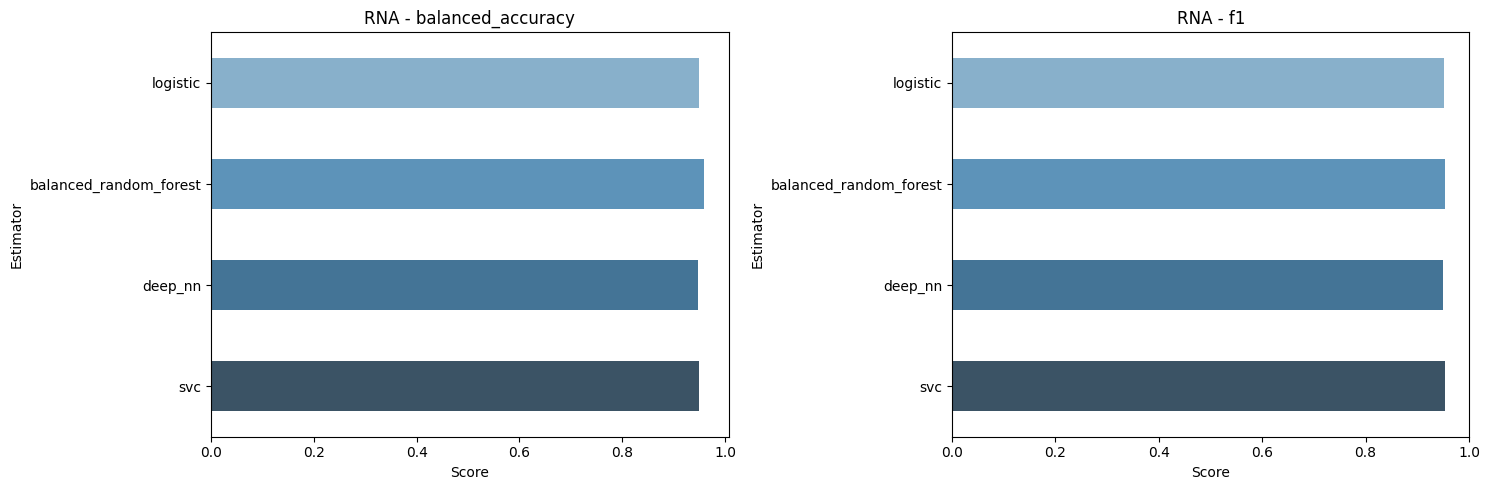

In [ ]:
plot_bar_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

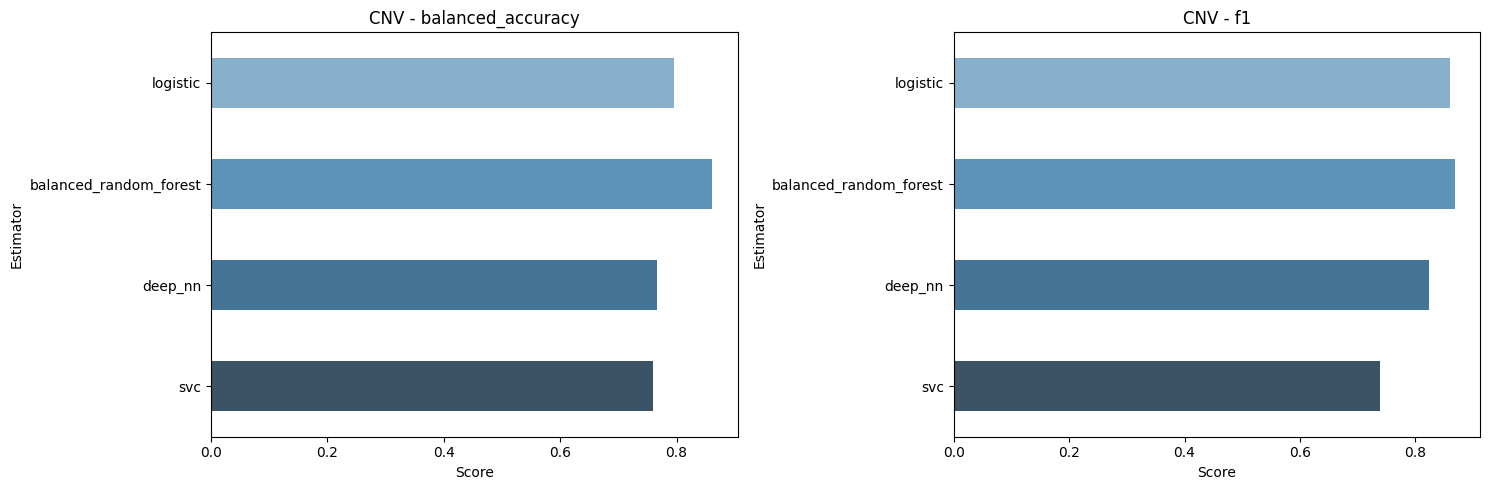

In [ ]:
plot_bar_scores(estimator_names, base_scores['cnv'], 'CNV', metrics=['balanced_accuracy', 'f1'])

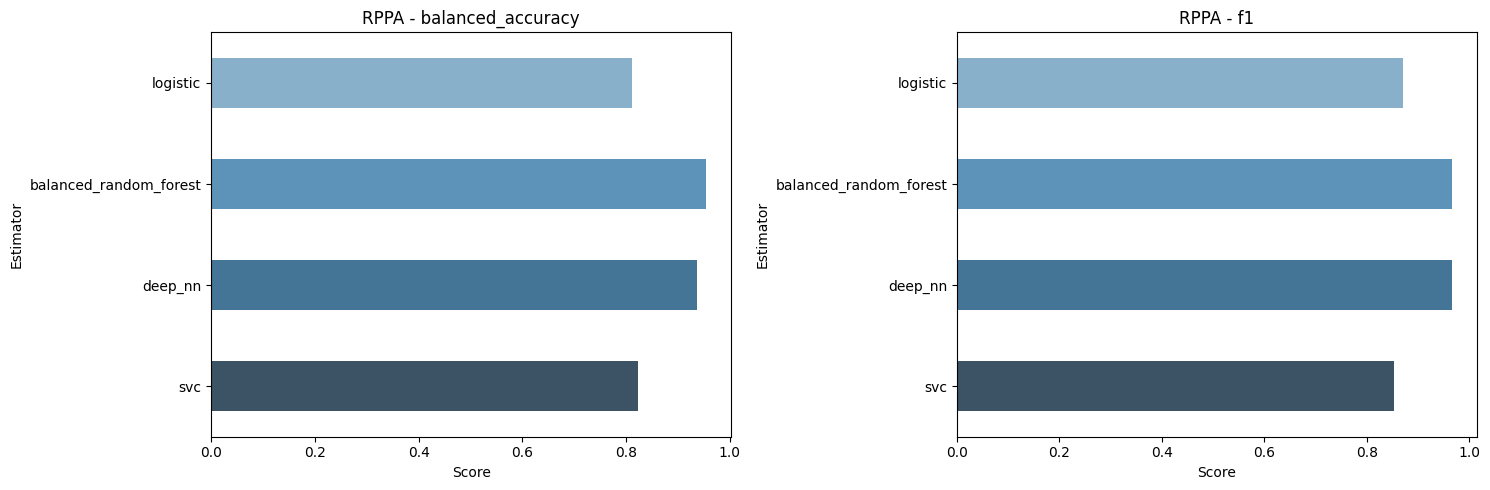

In [ ]:
plot_bar_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


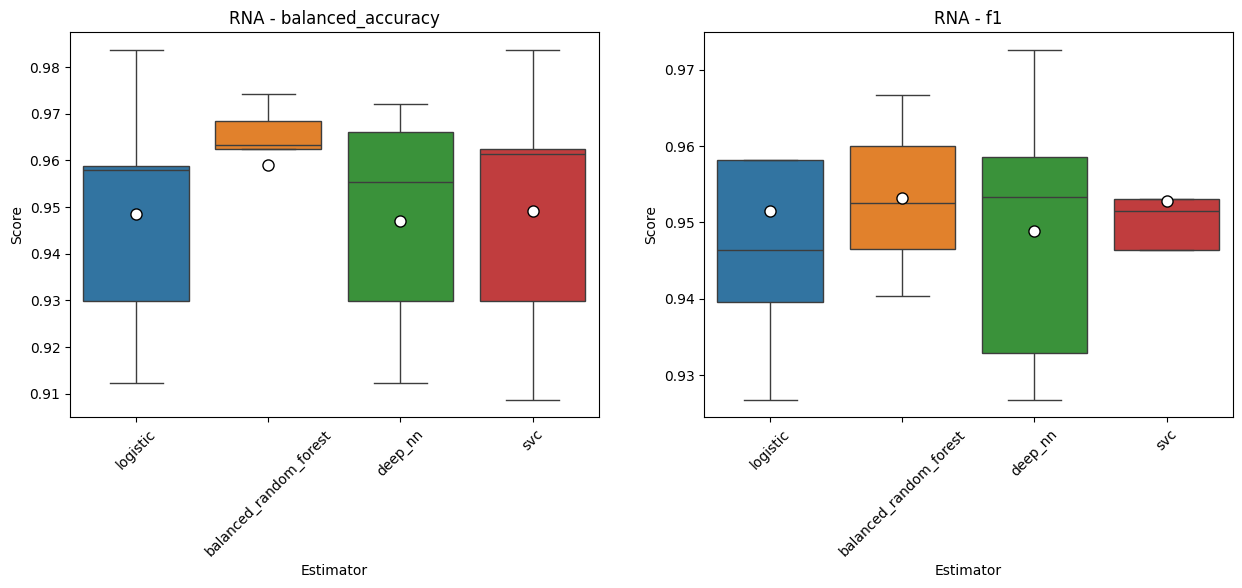

In [ ]:
plot_box_scores(estimator_names, base_scores['rna'], 'RNA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


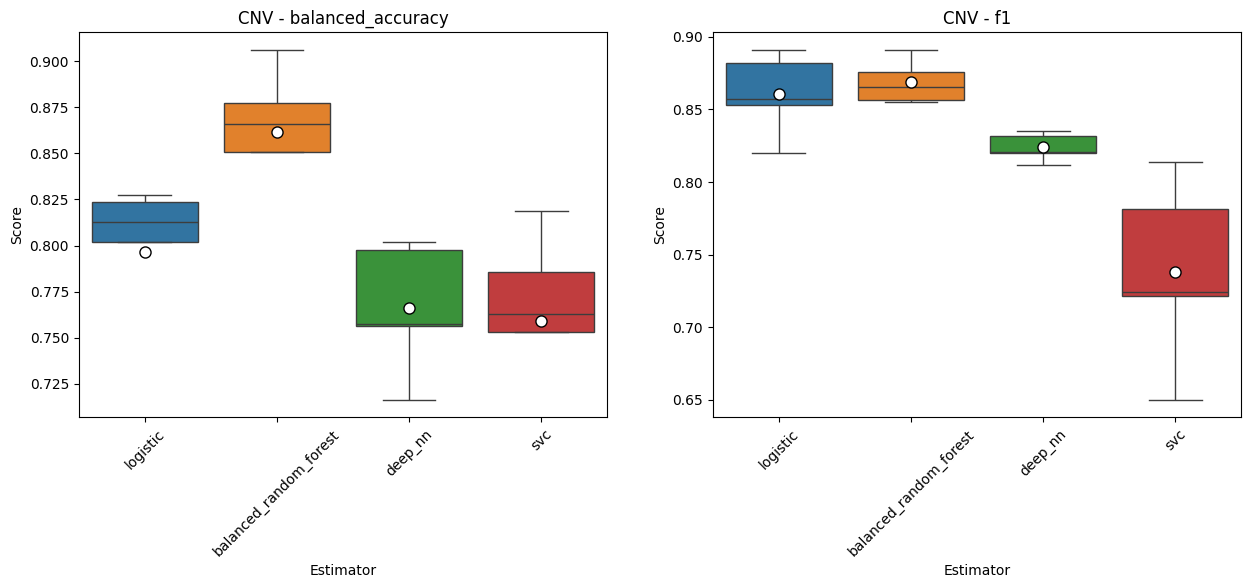

In [ ]:
plot_box_scores(estimator_names, base_scores['cnv'], 'CNV', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


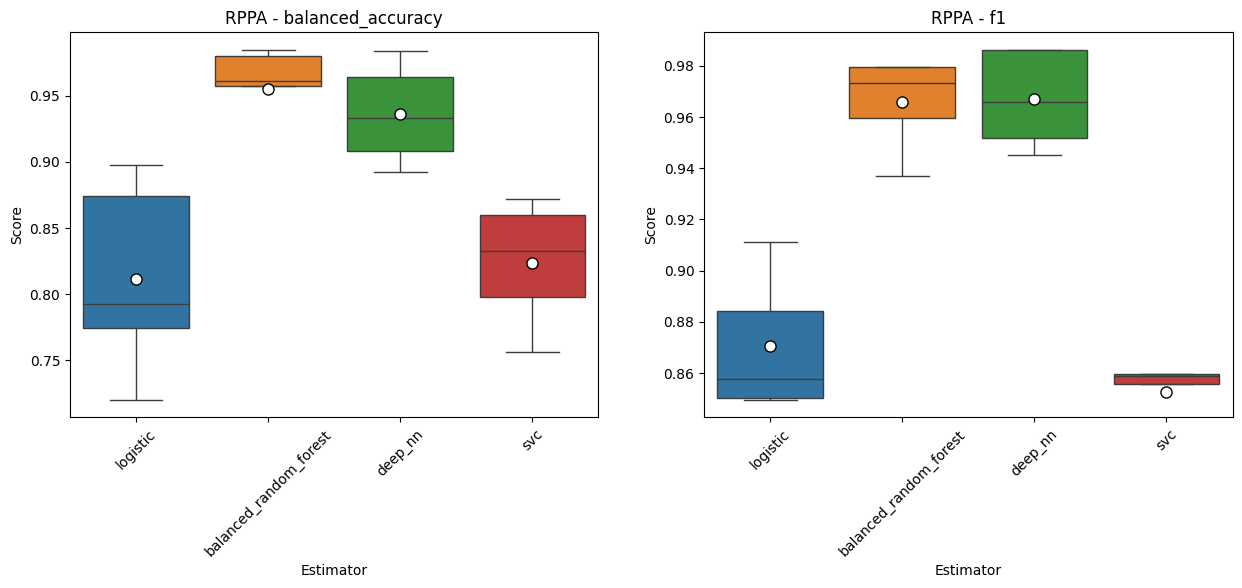

In [ ]:
plot_box_scores(estimator_names, base_scores['rppa'], 'RPPA', metrics=['balanced_accuracy', 'f1'])

## Modality Ensembles

In [22]:
classifiers = {}

for modality in datasets:
    classifiers[modality] = ModalityPipeline(estimators, cv=3)

In [ ]:
modality_metrics = pd.DataFrame()
scores = {}

for modality in tqdm(datasets):
    scores[modality], df = get_cross_metrics(classifiers[modality], X[modality], y, modality, scoring=kipan_scoring)
    modality_metrics = pd.concat([modality_metrics, df])

100%|██████████| 3/3 [02:13<00:00, 44.54s/it]


In [ ]:
modality_metrics

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna,0.952 +/- 0.019,0.949 +/- 0.024,0.953 +/- 0.018,0.938 +/- 0.090,0.953 +/- 0.031,0.956 +/- 0.024
cnv,0.880 +/- 0.022,0.835 +/- 0.034,0.879 +/- 0.023,0.778 +/- 0.101,0.931 +/- 0.020,0.796 +/- 0.096
rppa,0.973 +/- 0.012,0.953 +/- 0.023,0.973 +/- 0.012,0.922 +/- 0.049,0.991 +/- 0.011,0.947 +/- 0.028


In [ ]:
modality_metrics

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna,0.952 +/- 0.019,0.949 +/- 0.024,0.953 +/- 0.018,0.938 +/- 0.090,0.953 +/- 0.031,0.956 +/- 0.024
cnv,0.880 +/- 0.022,0.835 +/- 0.034,0.879 +/- 0.023,0.778 +/- 0.101,0.931 +/- 0.020,0.796 +/- 0.096
rppa,0.955 +/- 0.014,0.918 +/- 0.033,0.955 +/- 0.014,0.860 +/- 0.089,0.991 +/- 0.004,0.903 +/- 0.030


In [ ]:
estimator_names = [
    "logistic",
    "balanced_random_forest",
    "deep_nn",
    "svc",
    "stacking"
]
all_scores = {}

for modality in base_scores:
    all_scores[modality] = {}
    for i in range(len(base_scores[modality])):
        all_scores[modality][estimator_names[i]] = base_scores[modality][i]

    all_scores[modality]['stacking'] = scores[modality]


In [ ]:
# Convert and write JSON object to file
with open("results/kipan/subtyping/kipan_modality_results_2.json", "w") as outfile:
    json.dump(scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

In [ ]:
# Convert and write JSON object to file
with open("results/kipan/subtyping/kipan_base_learner_modality_results_2.json", "w") as outfile:
    json.dump(all_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

### Scoring

In [ ]:
all_metrics = {}

for modality in datasets:
    all_metrics[modality] = pd.concat([base_metrics_df[modality], modality_metrics.loc[[modality]]])
    all_metrics[modality].rename_axis(index={modality: 'stacking'}, inplace=True)

In [ ]:
display(all_metrics['rna'], all_metrics['cnv'], all_metrics['rppa'])

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.951 +/- 0.021,0.949 +/- 0.025,0.951 +/- 0.020,0.938 +/- 0.090,0.951 +/- 0.031,0.956 +/- 0.024
balanced_random_forest,0.952 +/- 0.010,0.959 +/- 0.017,0.953 +/- 0.009,0.969 +/- 0.062,0.946 +/- 0.021,0.961 +/- 0.020
deep_nn,0.948 +/- 0.017,0.947 +/- 0.023,0.949 +/- 0.017,0.938 +/- 0.090,0.947 +/- 0.029,0.956 +/- 0.024
svc,0.952 +/- 0.020,0.949 +/- 0.027,0.953 +/- 0.019,0.938 +/- 0.090,0.953 +/- 0.028,0.956 +/- 0.024
rna,0.952 +/- 0.019,0.949 +/- 0.024,0.953 +/- 0.018,0.938 +/- 0.090,0.953 +/- 0.031,0.956 +/- 0.024


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.863 +/- 0.024,0.796 +/- 0.041,0.860 +/- 0.025,0.685 +/- 0.126,0.923 +/- 0.028,0.781 +/- 0.073
balanced_random_forest,0.867 +/- 0.014,0.862 +/- 0.032,0.869 +/- 0.013,0.873 +/- 0.105,0.882 +/- 0.033,0.830 +/- 0.060
deep_nn,0.827 +/- 0.007,0.766 +/- 0.031,0.824 +/- 0.009,0.700 +/- 0.085,0.904 +/- 0.034,0.694 +/- 0.080
svc,0.731 +/- 0.058,0.759 +/- 0.047,0.738 +/- 0.056,0.794 +/- 0.109,0.698 +/- 0.073,0.786 +/- 0.081
cnv,0.880 +/- 0.022,0.835 +/- 0.034,0.879 +/- 0.023,0.778 +/- 0.101,0.931 +/- 0.020,0.796 +/- 0.096


,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
logistic,0.872 +/- 0.023,0.812 +/- 0.065,0.871 +/- 0.024,0.705 +/- 0.182,0.925 +/- 0.030,0.805 +/- 0.050
balanced_random_forest,0.966 +/- 0.015,0.955 +/- 0.033,0.966 +/- 0.016,0.953 +/- 0.062,0.985 +/- 0.009,0.927 +/- 0.055
deep_nn,0.967 +/- 0.017,0.936 +/- 0.034,0.967 +/- 0.017,0.876 +/- 0.078,0.991 +/- 0.011,0.942 +/- 0.036
svc,0.851 +/- 0.018,0.824 +/- 0.042,0.853 +/- 0.018,0.796 +/- 0.123,0.884 +/- 0.034,0.791 +/- 0.026
rppa,0.973 +/- 0.012,0.953 +/- 0.023,0.973 +/- 0.012,0.922 +/- 0.049,0.991 +/- 0.011,0.947 +/- 0.028


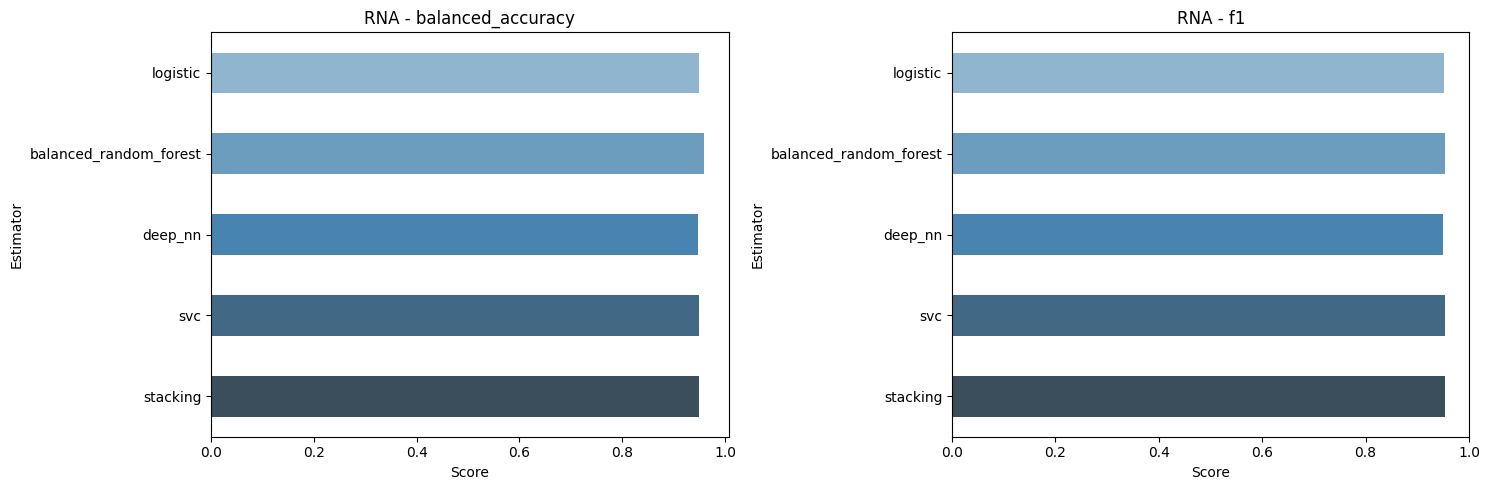

In [ ]:
plot_bar_scores(estimator_names, all_scores['rna'].values(), 'RNA', metrics=['balanced_accuracy', 'f1'])

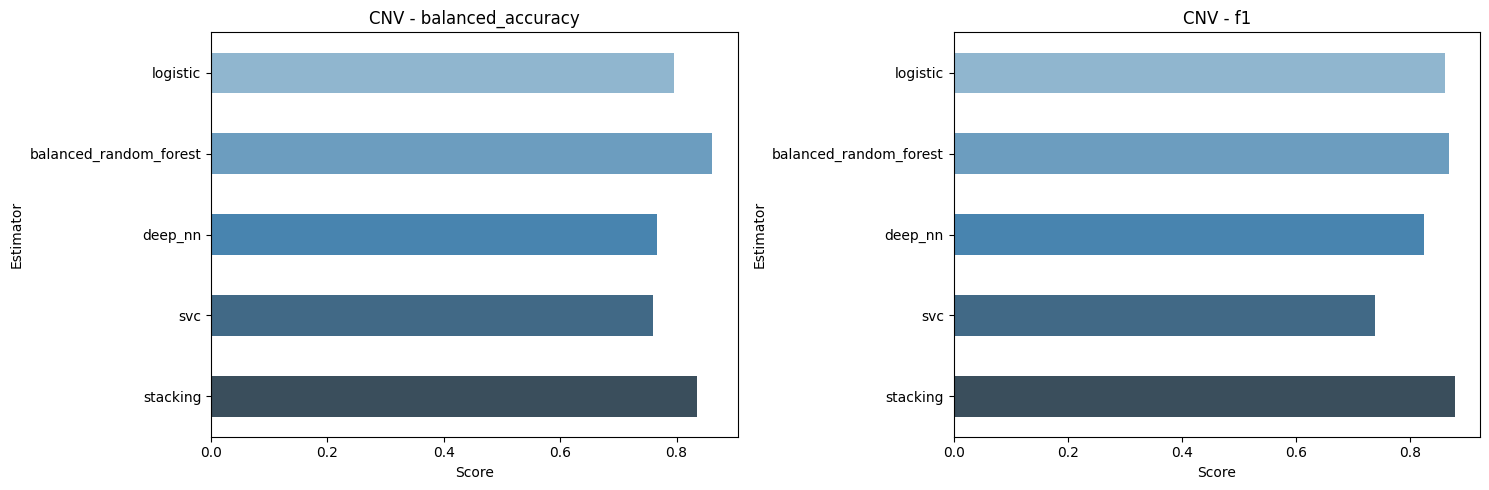

In [ ]:
plot_bar_scores(estimator_names, all_scores['cnv'].values(), 'CNV', metrics=['balanced_accuracy', 'f1'])

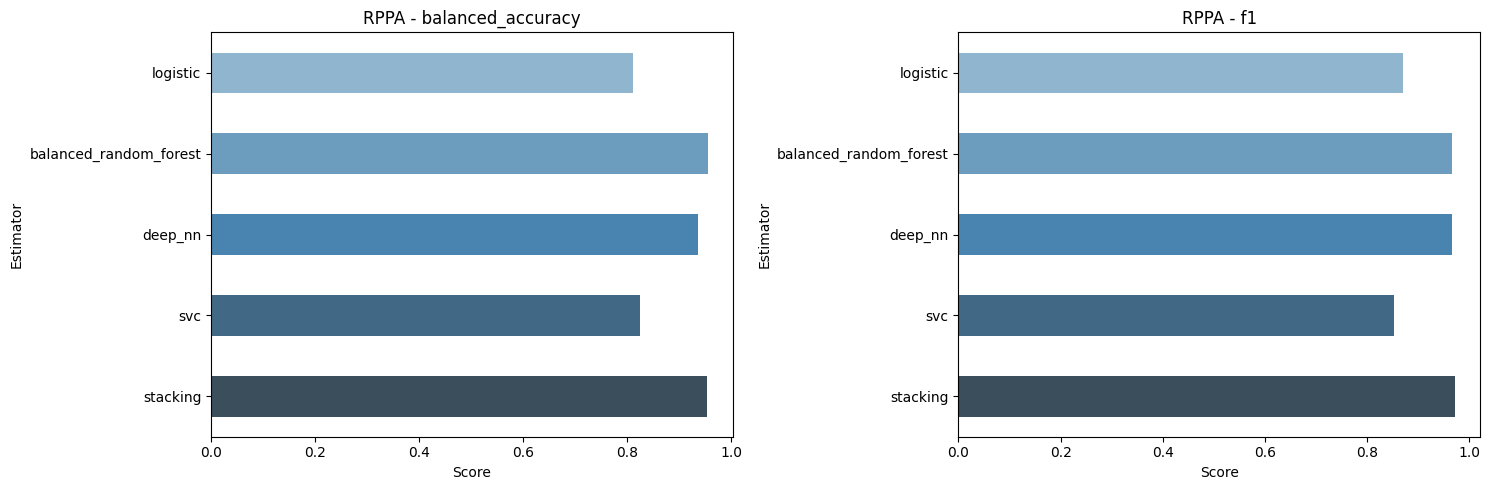

In [ ]:
plot_bar_scores(estimator_names, all_scores['rppa'].values(), 'RPPA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


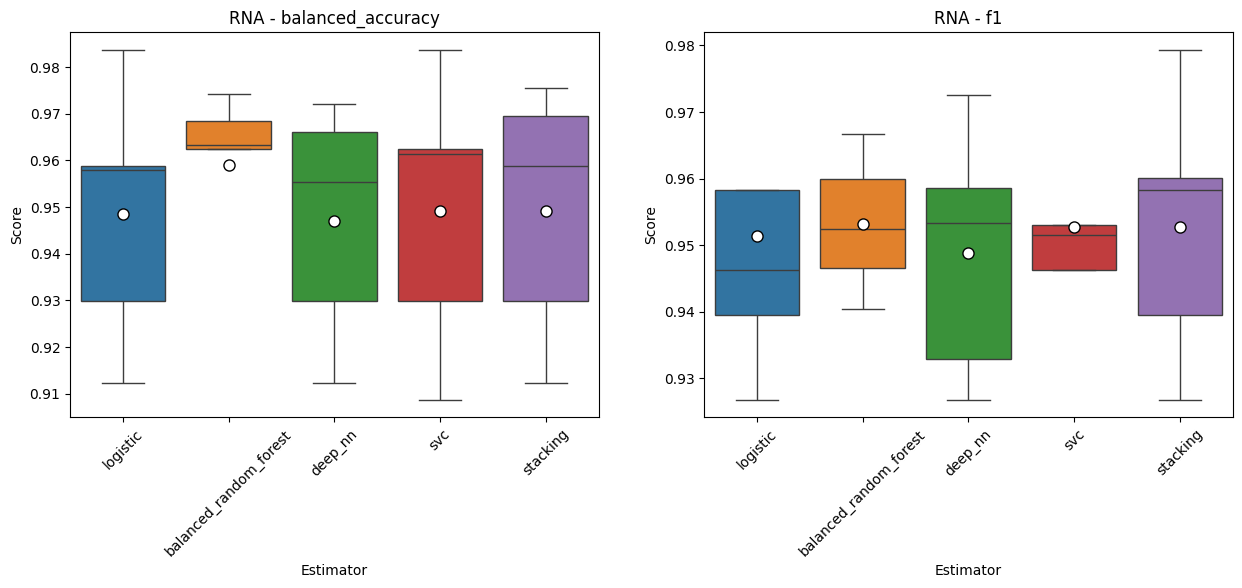

In [ ]:
plot_box_scores(estimator_names, all_scores['rna'].values(), 'RNA', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


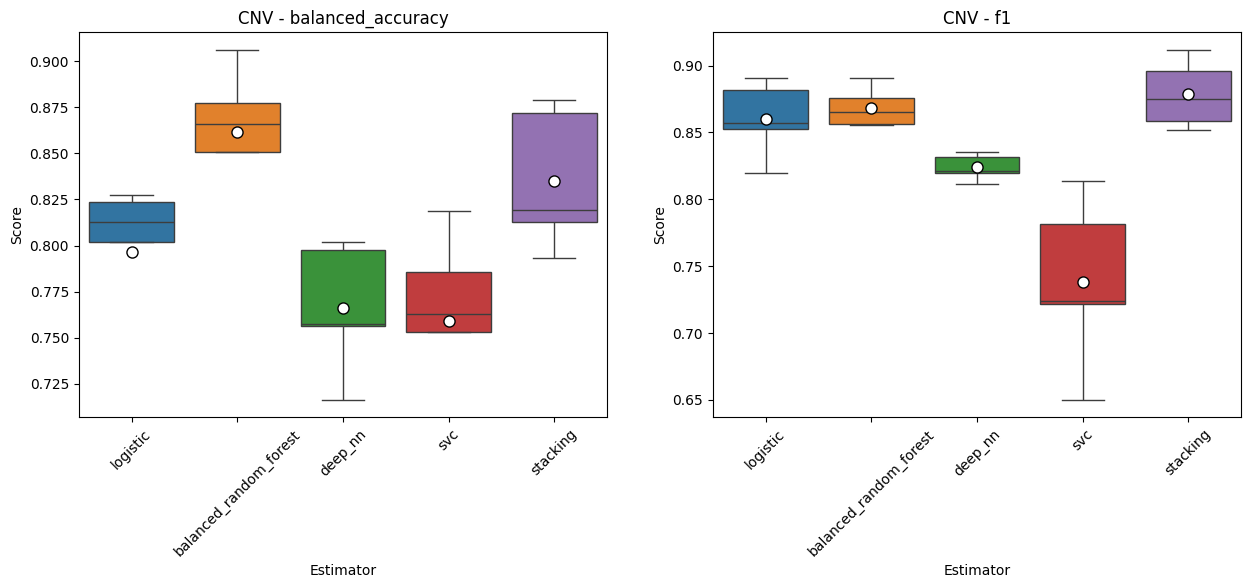

In [ ]:
plot_box_scores(estimator_names, all_scores['cnv'].values(), 'CNV', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


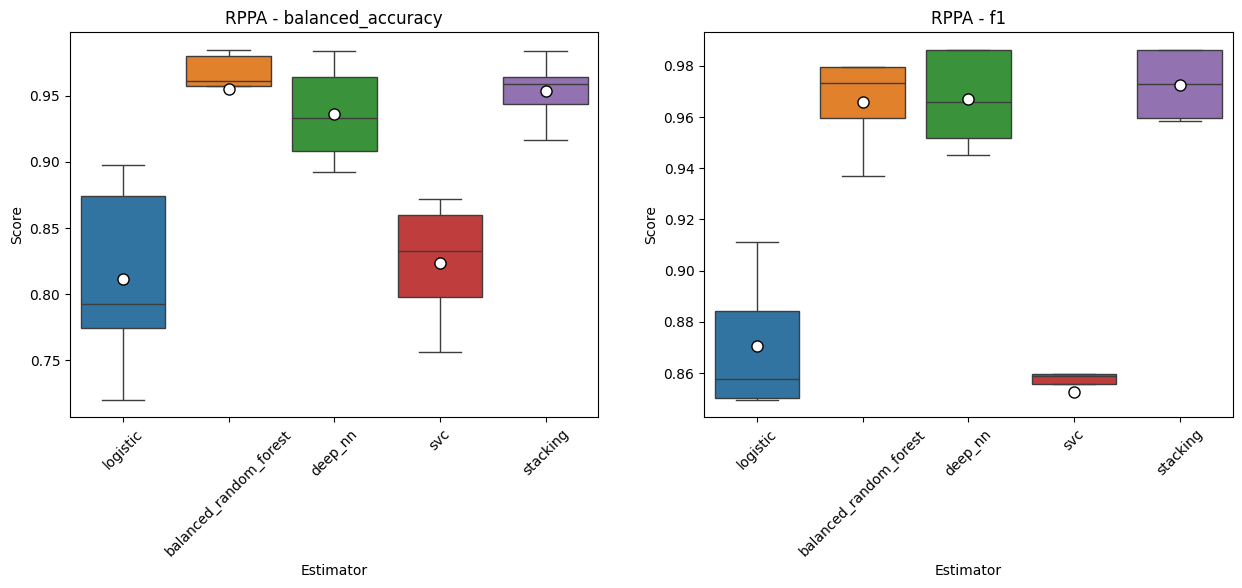

In [ ]:
plot_box_scores(estimator_names, all_scores['rppa'].values(), 'RPPA', metrics=['balanced_accuracy', 'f1'])

## Multi Omics Integration Ensemble

### Ensemble Model as a Custom Classifier

In [23]:
column_names = {}

for key in X.keys():
    column_names[key] = X[key].columns

In [24]:
meta_ensembles = {}
meta_ensembles['rna + cnv + rppa'] = MultiOmicsIntegrationClassifier(classifiers, cv=3)
meta_ensembles['cnv + rppa'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['cnv', 'rppa']}, cv=3)
meta_ensembles['rna + cnv'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['rna', 'cnv']}, cv=3)
meta_ensembles['rna + rppa'] = MultiOmicsIntegrationClassifier({key: classifiers[key] for key in ['rna', 'rppa']}, cv=3)

In [25]:
X_merged = {}
X_merged['rna + cnv + rppa'] = pd.concat([X['rna'], X['cnv'], X['rppa']], axis=1, join='inner')
X_merged['cnv + rppa'] = pd.concat([X['cnv'], X['rppa']], axis=1, join='inner')
X_merged['rna + cnv'] = pd.concat([X['rna'], X['cnv']], axis=1, join='inner')
X_merged['rna + rppa'] = pd.concat([X['rna'], X['rppa']], axis=1, join='inner')

In [ ]:
integration_scores = {}
integration_metrics = {}

In [ ]:
integration_scores['rna + cnv + rppa'], integration_metrics['rna + cnv + rppa'] = get_cross_metrics(meta_ensembles['rna + cnv + rppa'], X_merged['rna + cnv + rppa'], y, name='rna + cnv + rppa', cv=5, verbose=2, scoring=kipan_scoring, fit_params={'column_names': column_names})


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.5min finished


In [ ]:
integration_metrics['rna + cnv + rppa']

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna + cnv + rppa,0.974 +/- 0.013,0.964 +/- 0.033,0.974 +/- 0.013,0.938 +/- 0.090,0.979 +/- 0.019,0.976 +/- 0.022


In [ ]:
integration_scores['cnv + rppa'], integration_metrics['cnv + rppa'] = get_cross_metrics(meta_ensembles['cnv + rppa'], X_merged['cnv + rppa'], y, name='cnv + rppa', cv=5, verbose=2, scoring=kipan_scoring, fit_params={'column_names': {key: column_names[key] for key in ['cnv', 'rppa']}})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.5min finished


In [ ]:
integration_scores['rna + rppa'], integration_metrics['rna + rppa'] = get_cross_metrics(meta_ensembles['rna + rppa'], X_merged['rna + rppa'], y, name='rna + rppa', cv=5, verbose=2, scoring=kipan_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'rppa']}})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.9min finished


In [ ]:
integration_scores['rna + cnv'], integration_metrics['rna + cnv'] = get_cross_metrics(meta_ensembles['rna + cnv'], X_merged['rna + cnv'], y, name='rna + cnv', cv=5, verbose=2, scoring=kipan_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'cnv']}})

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.8min finished


In [ ]:
all_integration_metrics = pd.concat([modality_metrics, pd.concat([x for x in integration_metrics.values()])])
names = ['rna', 'cnv', 'rppa', 'rna + cnv + rppa', 'cnv + rppa', 'rna + rppa', 'rna + cnv']

all_integration_scores = scores

# Adding multi-omic ensemble scores
for name, value in integration_scores.items():
    all_integration_scores[name] = value

In [ ]:
all_integration_metrics

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
rna,0.952 +/- 0.019,0.949 +/- 0.024,0.953 +/- 0.018,0.938 +/- 0.090,0.953 +/- 0.031,0.956 +/- 0.024
cnv,0.880 +/- 0.022,0.835 +/- 0.034,0.879 +/- 0.023,0.778 +/- 0.101,0.931 +/- 0.020,0.796 +/- 0.096
rppa,0.973 +/- 0.012,0.953 +/- 0.023,0.973 +/- 0.012,0.922 +/- 0.049,0.991 +/- 0.011,0.947 +/- 0.028
rna + cnv + rppa,0.974 +/- 0.013,0.964 +/- 0.033,0.974 +/- 0.013,0.938 +/- 0.090,0.979 +/- 0.019,0.976 +/- 0.022
cnv + rppa,0.977 +/- 0.014,0.970 +/- 0.028,0.977 +/- 0.014,0.969 +/- 0.062,0.989 +/- 0.014,0.952 +/- 0.031
rna + rppa,0.978 +/- 0.016,0.965 +/- 0.031,0.978 +/- 0.016,0.938 +/- 0.090,0.987 +/- 0.021,0.971 +/- 0.010
rna + cnv,0.952 +/- 0.018,0.948 +/- 0.023,0.953 +/- 0.017,0.938 +/- 0.090,0.955 +/- 0.029,0.951 +/- 0.027


In [ ]:
# Convert and write JSON object to file
with open("results/kipan/subtyping/kipan_multi_omics_results_2.json", "w") as outfile:
    json.dump(integration_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

In [ ]:
# Convert and write JSON object to file
with open("results/kipan/subtyping/kipan_modality_multi_omics_results_2.json", "w") as outfile:
    json.dump(all_integration_scores, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

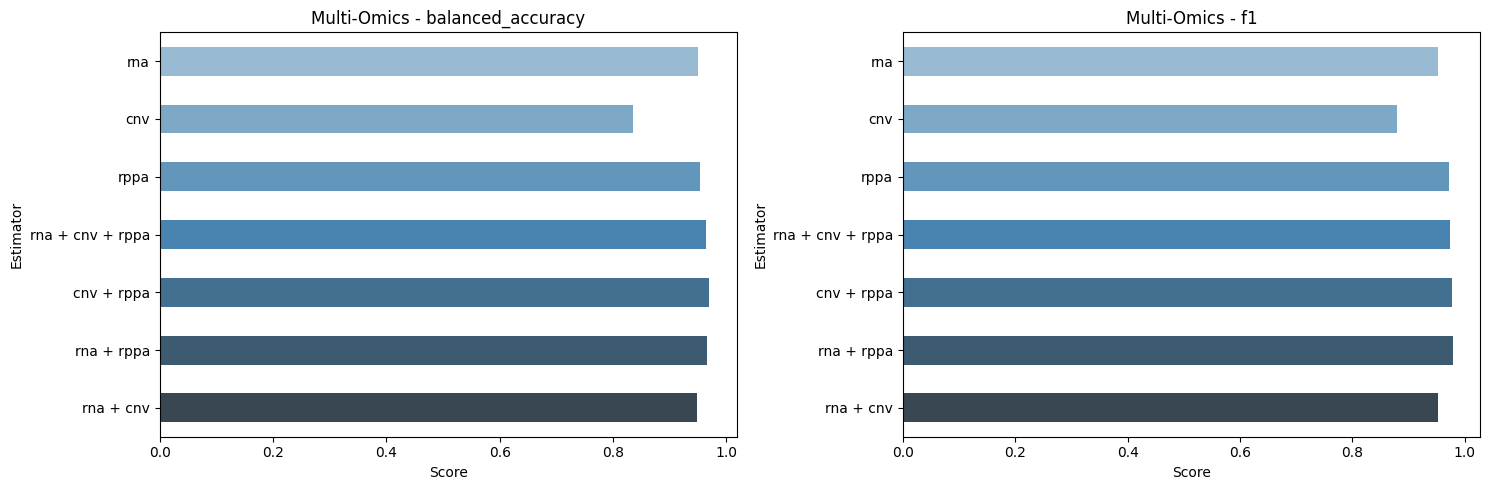

In [ ]:
plot_bar_scores(names, all_integration_scores.values(), 'Multi-Omics', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


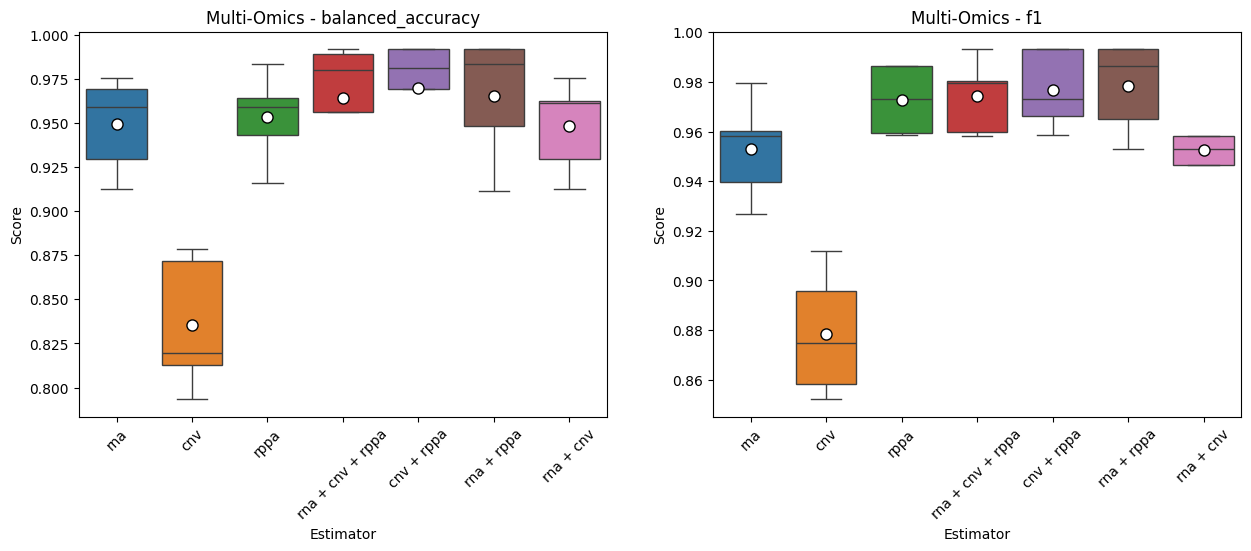

In [ ]:
plot_box_scores(names, all_integration_scores.values(), 'KIPAN Subtyping Multi-Omics', metrics=['balanced_accuracy', 'f1'])

## Statistical Significance

Now that we see the results, we want to check if the performance differences between our multi-omics ensemble models and the modality ensemble models are significant. We can employ the Wilcoxen test, using multiple replications of cross-validation to get scores.

### Wilcoxen

In [26]:
ensemble_results = {}
ensemble_metrics = {}

In [27]:
def wilcoxen_test(name_1, name_2, scores_1, scores_2):

    stat, p = wilcoxon(scores_1, scores_2, alternative='greater')

    df = pd.Series({'estimator_1': name_1, 'estimator_2': name_2, 'statistic': stat, 'p': p, 'significant': p <= 0.05})

    return pd.DataFrame(df).T

In [28]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
ensemble_results['cnv + rppa'], ensemble_metrics['cnv + rppa'] = get_cross_metrics(meta_ensembles['cnv + rppa'], X_merged['cnv + rppa'], y, name='cnv + rppa', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_scoring, fit_params={'column_names': {key: column_names[key] for key in ['cnv', 'rppa']}})
ensemble_results['rppa'], ensemble_metrics['rppa'] = get_cross_metrics(classifiers['rppa'], X['rppa'], y, name='rppa', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_scoring)


In [ ]:
ensemble_results['rna + rppa'], ensemble_metrics['rna + rppa'] = get_cross_metrics(meta_ensembles['rna + rppa'], X_merged['rna + rppa'], y, name='rna + rppa', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_scoring, fit_params={'column_names': {key: column_names[key] for key in ['rna', 'rppa']}})

In [ ]:
ensemble_results['rna'], ensemble_metrics['rna'] = get_cross_metrics(classifiers['rna'], X['rna'], y, name='rna', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_scoring)

In [ ]:
ensemble_results['rna + cnv + rppa'], ensemble_metrics['rna + cnv + rppa'] = get_cross_metrics(meta_ensembles['rna + cnv + rppa'], X_merged['rna + cnv + rppa'], y, name='rna + cnv + rppa', cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1), scoring=kipan_scoring, fit_params={'column_names': column_names})

In [ ]:
# Picking models we want to compare performances for
compare = [
    ('cnv + rppa', 'rppa'),
    ('rna + rppa', 'rna'),
    ('rna + cnv + rppa', 'rna')
]

In [ ]:
from scipy.stats import wilcoxon

wilcoxen_results = {}
metrics = ['balanced_accuracy', 'f1']

for metric in metrics:
    wilcoxen_results[metric] = pd.DataFrame()
    for est1, est2 in compare:
        df = wilcoxen_test(est1, est2, ensemble_results_2[est1]['test_' + metric], ensemble_results_2[est2]['test_' + metric])
        wilcoxen_results[metric] = pd.concat([wilcoxen_results[metric], df])


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [ ]:
display(wilcoxen_results['balanced_accuracy'], wilcoxen_results['f1'])

,estimator_1,estimator_2,statistic,p,significant
0,cnv + rppa,rppa,66.0,0.001673,True
0,rna + rppa,rna,119.0,0.000061,True
0,rna + cnv + rppa,rna,108.0,0.002136,True


,estimator_1,estimator_2,statistic,p,significant
0,cnv + rppa,rppa,66.0,0.001673,True
0,rna + rppa,rna,120.0,0.000031,True
0,rna + cnv + rppa,rna,120.0,0.000031,True


In [31]:
# Run this if continuing an already saved run:
with open("results/kipan/subtyping/kipan_5x3_results.json",'r+') as file:
    ensemble_results_2 = json.load(file)
    ensemble_metrics_2 = pd.DataFrame()

    for model in ensemble_results_2:
      metrics = {}

      for scorer in kipan_scoring:
        metrics[scorer] = []

      for scorer in kipan_scoring:
          metrics[scorer].append(
              "%0.3f +/- %0.3f"
              % (np.mean(ensemble_results_2[model]["test_%s" % scorer]), np.std(ensemble_results_2[model]["test_%s" % scorer]))
      )
      ensemble_metrics_2 = pd.concat([ensemble_metrics_2, pd.DataFrame(metrics, index=[model])])

KeyError: 'test_recall (KICH)'

In [30]:
ensemble_metrics_2

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
cnv + rppa,0.977 +/- 0.012,0.965 +/- 0.024,0.977 +/- 0.012,0.943 +/- 0.066,0.989 +/- 0.014,0.963 +/- 0.025
rppa,0.969 +/- 0.015,0.931 +/- 0.039,0.968 +/- 0.016,0.848 +/- 0.108,0.992 +/- 0.009,0.953 +/- 0.026
rna + rppa,0.984 +/- 0.013,0.974 +/- 0.025,0.984 +/- 0.013,0.959 +/- 0.056,0.994 +/- 0.007,0.969 +/- 0.025
rna,0.961 +/- 0.021,0.958 +/- 0.029,0.961 +/- 0.021,0.948 +/- 0.061,0.961 +/- 0.022,0.966 +/- 0.032
rna + cnv + rppa,0.977 +/- 0.017,0.969 +/- 0.027,0.977 +/- 0.017,0.953 +/- 0.055,0.984 +/- 0.016,0.968 +/- 0.032


/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


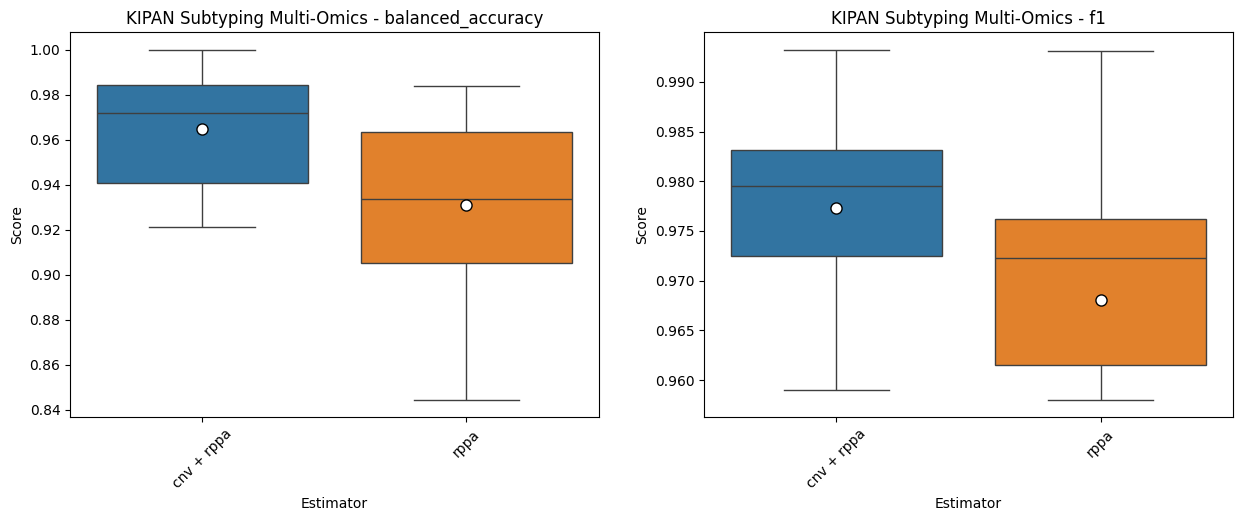

In [ ]:
plot_box_scores(['cnv + rppa', 'rppa'], [ensemble_results['cnv + rppa'], ensemble_results['rppa']], 'KIPAN Subtyping Multi-Omics', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


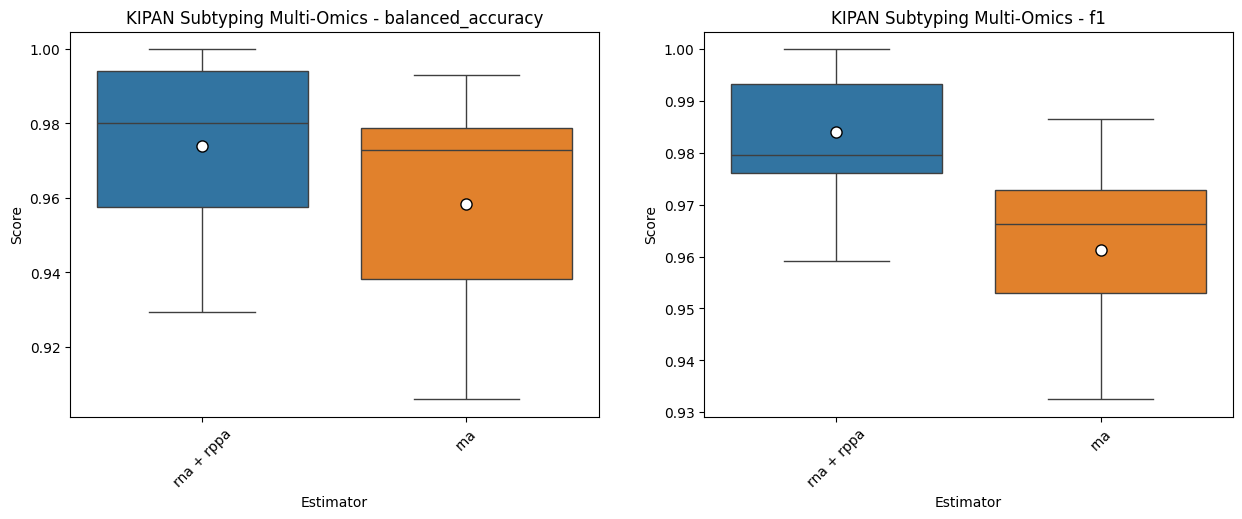

In [ ]:
plot_box_scores(['rna + rppa', 'rna'], [ensemble_results['rna + rppa'], ensemble_results['rna']], 'KIPAN Subtyping Multi-Omics', metrics=['balanced_accuracy', 'f1'])

/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)
/content/drive/MyDrive/MultiOmicsIntegration/comp-401/multi_omics_integration/evaluation.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(estimator_names, rotation=45)


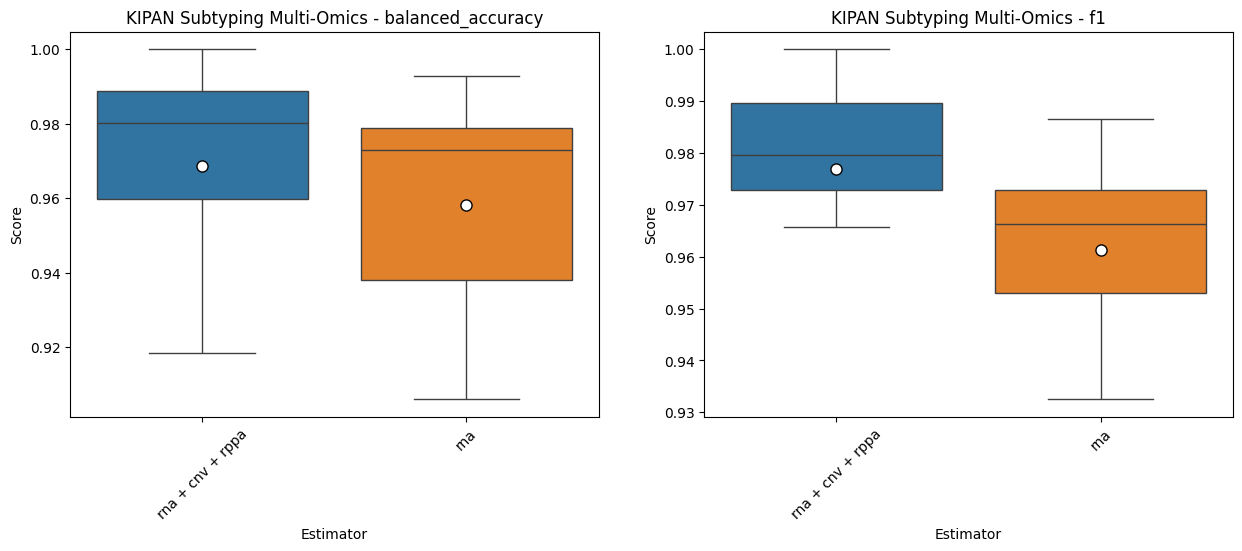

In [ ]:
plot_box_scores(['rna + cnv + rppa', 'rna'], [ensemble_results['rna + cnv + rppa'], ensemble_results['rna']], 'KIPAN Subtyping Multi-Omics', metrics=['balanced_accuracy', 'f1'])

In [ ]:
# Convert and write JSON object to file
with open("results/kipan/subtyping/kipan_5x3_results.json", "w") as outfile:
    json.dump(ensemble_results_2, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

## Feature Importance

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [ ]:
# Splitting into training, validation
X_train, X_test, y_train, y_test = train_test_split(X_merged['rna + cnv + rppa'], y, random_state=0, stratify=y)

In [ ]:
# Fitting on training data
meta_ensembles['rna + cnv + rppa'].fit(X_train, y_train, column_names)

MultiOmicsIntegrationClassifier(cv=3,
                                estimator_dict={'cnv': ModalityPipeline(cv=3,
                                                                        estimator_list=[('logistic',
                                                                                         Pipeline(steps=[('standardscaler',
                                                                                                          StandardScaler()),
                                                                                                         ('logisticregression',
                                                                                                          LogisticRegression(max_iter=1000,
                                                                                                                             n_jobs=-1,
                                                                                                                             random_state=0))])),
                                                                                        ('balanced_random_forest',
                                                                                         BalancedRandomForestClassifier(n_jobs=-1,
                                                                                                                        random_state=0,
                                                                                                                        replacement=True,
                                                                                                                        sampl...
                                                                                         ('balanced_random_forest',
                                                                                          BalancedRandomForestClassifier(n_jobs=-1,
                                                                                                                         random_state=0,
                                                                                                                         replacement=True,
                                                                                                                         sampling_strategy='all')),
                                                                                         ('deep_nn',
                                                                                          Pipeline(steps=[('standardscaler',
                                                                                                           StandardScaler()),
                                                                                                          ('mlpclassifier',
                                                                                                           MLPClassifier(random_state=0))])),
                                                                                         ('svc',
                                                                                          Pipeline(steps=[('standardscaler',
                                                                                                           StandardScaler()),
                                                                                                          ('svc',
                                                                                                           SVC(kernel='linear',
                                                                                                               max_iter=1000,
                                                                                                               random_state=0))]))])})

In [ ]:
# Getting baseline scores
baseline_scores = {}
for name, scorer in kipan_scoring.items():
  baseline_scores[name] = get_scorer(scorer)(meta_ensembles['rna + cnv + rppa'], X_test, y_test)

In [ ]:
pd.DataFrame(baseline_scores, index=[""])

,accuracy,balanced_accuracy,f1,recall (KICH),recall (KIRC),recall (KIRP)
,0.978261,0.966933,0.978261,0.9375,0.982906,0.980392


In [ ]:
result = permutation_importance(meta_ensembles['rna + cnv + rppa'], X_test, y_test, n_repeats=10, random_state=0, scoring=kipan_scoring, n_jobs=-1)

In [ ]:
sorted_importances_idx = result['balanced_accuracy'].importances_mean.argsort()
importances = pd.DataFrame(
    result['balanced_accuracy'].importances[sorted_importances_idx].T,
    columns=X_merged['rna + cnv + rppa'].columns[sorted_importances_idx],
)

importances.head()

,KIT_rna,ATP6V0D2_rna,TMPRSS2_rna,RPTOR|Raptor_RPPA,PLA2G4F_rna,RHCG_rna,FABP7_rna,NTN1_rna,MYO7B_rna,NFKB1|NF-kB-p65_pS536_RPPA,...,GATA3|GATA3_RPPA,EIF4EBP1|4E-BP1_RPPA,TGM2|Transglutaminase_RPPA,RAB25|Rab25_RPPA,DVL3|Dvl3_RPPA,ERBB2|HER2_RPPA,CCNB1|Cyclin_B1_RPPA,ERBB2|HER2_pY1248_RPPA,PRKAA1|AMPK_pT172_RPPA,CDH2|N-Cadherin_RPPA
0,-0.002849,-0.002849,-0.002849,0.000000,-0.002849,-0.002849,-0.002849,-0.002849,-0.002849,0.000000,...,0.012234,0.000000,0.017984,0.020833,0.000000,0.002849,0.000000,0.000000,0.020833,0.020833
1,-0.002849,-0.002849,-0.002849,0.002849,0.000000,0.000000,-0.002849,0.000000,-0.002849,0.000000,...,0.002849,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002849,0.020833
2,-0.002849,-0.002849,-0.002849,-0.006536,-0.002849,-0.002849,-0.002849,0.000000,-0.002849,-0.002849,...,0.006536,0.000000,0.020833,0.041667,0.000000,0.002849,0.000000,0.000000,0.000000,0.020833
3,-0.002849,-0.002849,-0.002849,-0.006536,-0.002849,-0.002849,0.000000,-0.002849,-0.002849,0.000000,...,0.000000,-0.002849,-0.002849,0.000000,0.020833,0.000000,0.000000,0.020833,0.000000,0.002849
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.020833,0.000000,0.000000,0.020833,0.020833,0.020833,0.020833,0.000000,0.020833


In [ ]:
importances.iloc[:, -20:].columns

Index(['YWHAZ|14-3-3_zeta_RPPA', 'AR|AR_RPPA', 'MSH2|MSH2_RPPA',
       'CHEK2|Chk2_RPPA', 'BAK1|Bak_RPPA', 'ACVRL1|ACVRL1_RPPA',
       'EGFR|EGFR_RPPA', 'MAP2K1|MEK1_pS217_S221_RPPA', 'PIK3R1|PI3K-p85_RPPA',
       'AKT1S1|PRAS40_pT246_RPPA', 'GATA3|GATA3_RPPA', 'EIF4EBP1|4E-BP1_RPPA',
       'TGM2|Transglutaminase_RPPA', 'RAB25|Rab25_RPPA', 'DVL3|Dvl3_RPPA',
       'ERBB2|HER2_RPPA', 'CCNB1|Cyclin_B1_RPPA', 'ERBB2|HER2_pY1248_RPPA',
       'PRKAA1|AMPK_pT172_RPPA', 'CDH2|N-Cadherin_RPPA'],
      dtype='object')

Text(0, 0.5, 'Genes')

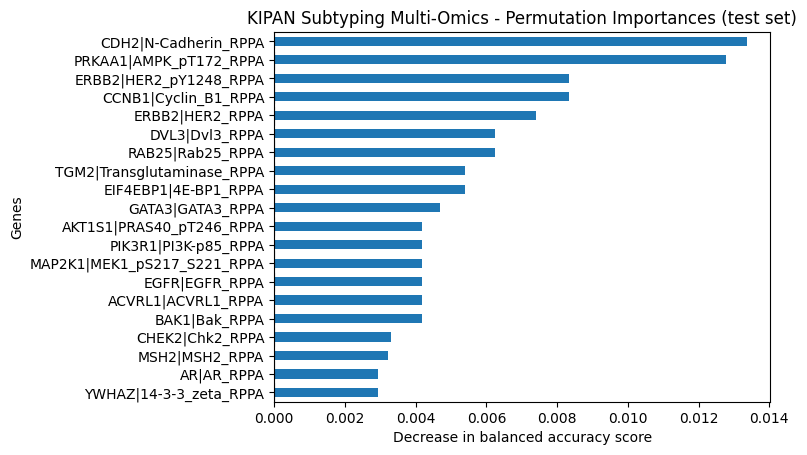

In [ ]:
# Printing top 20 important features
ax = importances.mean()[-20:].plot(kind='barh')
ax.set_title("KIPAN Subtyping Multi-Omics - Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in balanced accuracy score")
ax.set_ylabel('Genes')

Text(0, 0.5, 'Genes')

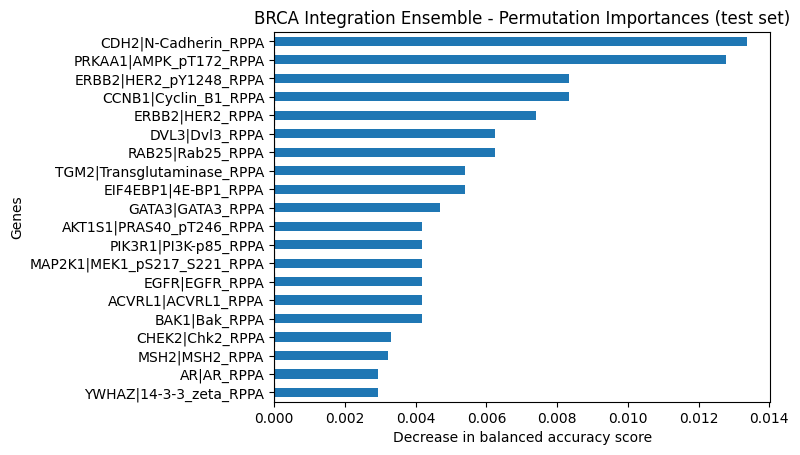

In [ ]:
# Printing top 20 important features
ax = importances.mean()[-20:].plot(kind='barh')
ax.set_title("KIPAN Integration Ensemble - Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in balanced accuracy score")
ax.set_ylabel('Genes')

In [ ]:
top_genes = []

for i in result['balanced_accuracy'].importances_mean.argsort()[::-1]:
     if result['balanced_accuracy'].importances_mean[i] > 0:
        top_genes.append(X_merged['rna + cnv + rppa'].columns[i])
        print(f"{X_merged['rna + cnv + rppa'].columns[i]:<8}  "
               f"{result['balanced_accuracy'].importances_mean[i]:.4f}"
               f" +/- {result['balanced_accuracy'].importances_std[i]:.4f}")

CDH2|N-Cadherin_RPPA  0.0134 +/- 0.0098
PRKAA1|AMPK_pT172_RPPA  0.0128 +/- 0.0099
ERBB2|HER2_pY1248_RPPA  0.0083 +/- 0.0102
CCNB1|Cyclin_B1_RPPA  0.0083 +/- 0.0102
ERBB2|HER2_RPPA  0.0074 +/- 0.0095
DVL3|Dvl3_RPPA  0.0063 +/- 0.0095
RAB25|Rab25_RPPA  0.0063 +/- 0.0133
TGM2|Transglutaminase_RPPA  0.0054 +/- 0.0090
EIF4EBP1|4E-BP1_RPPA  0.0054 +/- 0.0089
GATA3|GATA3_RPPA  0.0047 +/- 0.0040
AKT1S1|PRAS40_pT246_RPPA  0.0042 +/- 0.0083
PIK3R1|PI3K-p85_RPPA  0.0042 +/- 0.0083
MAP2K1|MEK1_pS217_S221_RPPA  0.0042 +/- 0.0083
EGFR|EGFR_RPPA  0.0042 +/- 0.0083
ACVRL1|ACVRL1_RPPA  0.0042 +/- 0.0083
BAK1|Bak_RPPA  0.0042 +/- 0.0083
CHEK2|Chk2_RPPA  0.0033 +/- 0.0071
MSH2|MSH2_RPPA  0.0032 +/- 0.0069
AR|AR_RPPA  0.0029 +/- 0.0070
YWHAZ|14-3-3_zeta_RPPA  0.0029 +/- 0.0024
EGFR|EGFR_pY1068_RPPA  0.0026 +/- 0.0015
IRS1|IRS1_RPPA  0.0024 +/- 0.0062
EIF4G1|eIF4G_RPPA  0.0024 +/- 0.0062
YBX1|YB-1_pS102_RPPA  0.0023 +/- 0.0011
ERCC1|ERCC1_RPPA  0.0023 +/- 0.0017
MYH11|MYH11_RPPA  0.0022 +/- 0.0032
PEA15|PE

In [ ]:
top_genes_modality = {}

for modality in datasets:
  top_genes_modality[modality] = []

for gene in top_genes:
  for modality in datasets:
    if ("_" + modality) in gene.lower():
      #top_genes_modality[modality].append(gene.removesuffix('_'+modality))
      top_genes_modality[modality].append(gene)
      break

In [ ]:
# Printing to copy-paste into top-gene for enrichment analysis
for modality in top_genes_modality:
  print(f"{modality}: " + ','.join(top_genes_modality[modality]))
  print("")

rna: 

cnv: LARGE_cnv,SEMA3E_cnv,ZNF716_cnv,MIR3147_cnv,ZNF479_cnv,RN7SL816P_cnv,SGCG_cnv,CDH18_cnv,CLIC6_cnv,CADM2_cnv,AKAP4_cnv,RN7SL740P_cnv,LINC00310_cnv,BIVM_cnv,RCAN1_cnv,TPGS2_cnv,OXR1_cnv,LINC00283_cnv,TEX30_cnv,KDELC1_cnv,ABRA_cnv,CCNB3_cnv,GPR56_cnv,MIR5688_cnv,LINC00649_cnv,FAR2_cnv,snoU13|ENSG00000238865.1_cnv,ATP5O_cnv,PCLO_cnv,RN7SL109P_cnv,MIS18A_cnv,DGKK_cnv,ANKRD11_cnv,RN7SKP284_cnv,MIR3920_cnv,C8orf86_cnv,RHOV_cnv,ZC3H12B_cnv,SPINT1_cnv,CELF4_cnv,LAS1L_cnv,OPHN1_cnv,SLC14A2_cnv,VGLL3_cnv,MYO5B_cnv,MIR4795_cnv,TMCC1_cnv,TRPC6_cnv,CDC73_cnv,PLXNA2_cnv,CAMK1D_cnv,PGR_cnv,SLC30A10_cnv,SNTG1_cnv,DSG3_cnv,CCDC120_cnv,PAK7_cnv,SLC39A11_cnv

rppa: CDH2|N-Cadherin_RPPA,PRKAA1|AMPK_pT172_RPPA,ERBB2|HER2_pY1248_RPPA,CCNB1|Cyclin_B1_RPPA,ERBB2|HER2_RPPA,DVL3|Dvl3_RPPA,RAB25|Rab25_RPPA,TGM2|Transglutaminase_RPPA,EIF4EBP1|4E-BP1_RPPA,GATA3|GATA3_RPPA,AKT1S1|PRAS40_pT246_RPPA,PIK3R1|PI3K-p85_RPPA,MAP2K1|MEK1_pS217_S221_RPPA,EGFR|EGFR_RPPA,ACVRL1|ACVRL1_RPPA,BAK1|Bak_RPPA,CHEK2|Chk2_

In [ ]:
# Convert and write csv object to file
with open("results/kipan/subtyping/permutation_results.csv", "w") as outfile:
    importances.to_csv(outfile)

In [ ]:
with open("results/kipan/subtyping/marker_genes.json", "w") as outfile:
    json.dump(top_genes_modality, outfile, default=lambda x: x.tolist() if isinstance(x, np.ndarray) else x)